<a href="https://colab.research.google.com/github/perezrmaria/intonation_analysis/blob/main/direction_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install pretty_midi


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import pretty_midi
from tqdm import tqdm

import scipy
import scipy.signal as signal
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from matplotlib.colors import LinearSegmentedColormap

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sys.path.append('/content/drive/Shareddrives/Master Thesis')
import midi_functions
import peak_functions
import freqvibrato_functions
import dict_functions


In [5]:
gradestoNote_C_Maj = {'I':'C', 'II':'D', 'III':'E', 'IV':'F', 'V':'G', 'VI':'A', 'VII':'B'}
gradestoNote_G_Maj = {'I':'G', 'II':'A', 'III':'B', 'IV':'C', 'V':'D', 'VI':'E', 'VII':'F#'}
gradestoNote_F_Maj = {'I':'F', 'II':'G', 'III':'A', 'IV':'A#', 'V':'C', 'VI':'D', 'VII':'E'}
gradestoNote_Eb_Maj = {'I':'D#', 'II':'F', 'III':'G', 'IV':'G#', 'V':'A#', 'VI':'C', 'VII':'D'}
gradestoNote_A_Maj = {'I':'A', 'II':'B', 'III':'C#', 'IV':'D', 'V':'E', 'VI':'F#', 'VII':'G#'}

notetoGrades_C_Maj = {'C':'I', 'D':'II', 'E':'III', 'F':'IV', 'G':'V', 'A':'VI', 'B':'VII'}
notetoGrades_G_Maj = {'G':'I', 'A':'II', 'B':'III', 'C':'IV', 'D':'V', 'E':'VI', 'F#':'VII'}
notetoGrades_F_Maj = {'F':'I', 'G':'II', 'A':'III', 'A#':'IV', 'C':'V', 'D':'VI', 'E':'VII'}
notetoGrades_Eb_Maj = {'D#':'I', 'F':'II', 'G':'III', 'G#':'IV', 'A#':'V', 'C':'VI', 'D':'VII'}
notetoGrades_A_Maj = {'A':'I', 'B':'II', 'C#':'III', 'D':'IV', 'E':'V', 'F#':'VI', 'G#':'VII'}


tonalities = {'C':notetoGrades_C_Maj, 'G':notetoGrades_G_Maj, 'F':notetoGrades_F_Maj, 'Eb':notetoGrades_Eb_Maj, 'A':notetoGrades_A_Maj}
tonalities_etudes = {'Wohlfahrt-Op45-01': 'C', 'Wohlfahrt-Op45-03': 'G', 'Wohlfahrt-Op45-05': 'F', 'Wohlfahrt-Op45-10': 'A', 'Wohlfahrt-Op45-11': 'Eb', 'Wohlfahrt-Op45-15': 'C', 'Wohlfahrt-Op45-26': 'G'}
tonalities_etudes_no26 = {'Wohlfahrt-Op45-01': 'C', 'Wohlfahrt-Op45-03': 'G', 'Wohlfahrt-Op45-05': 'F', 'Wohlfahrt-Op45-10': 'A', 'Wohlfahrt-Op45-11': 'Eb', 'Wohlfahrt-Op45-15': 'C'}

tonalities_etudes_gradestoNote = {'Wohlfahrt-Op45-01': {'I':'C', 'II':'D', 'III':'E', 'IV':'F', 'V':'G', 'VI':'A', 'VII':'B'}, 'Wohlfahrt-Op45-03': {'I':'G', 'II':'A', 'III':'B', 'IV':'C', 'V':'D', 'VI':'E', 'VII':'F#'}, 'Wohlfahrt-Op45-05': {'I':'F', 'II':'G', 'III':'A', 'IV':'A#', 'V':'C', 'VI':'D', 'VII':'E'}, 'Wohlfahrt-Op45-10': {'I':'A', 'II':'B', 'III':'C#', 'IV':'D', 'V':'E', 'VI':'F#', 'VII':'G#'}, 'Wohlfahrt-Op45-11': {'I':'D#', 'II':'F', 'III':'G', 'IV':'G#', 'V':'A#', 'VI':'C', 'VII':'D'}, 'Wohlfahrt-Op45-15': {'I':'C', 'II':'D', 'III':'E', 'IV':'F', 'V':'G', 'VI':'A', 'VII':'B'}, 'Wohlfahrt-Op45-26': {'I':'G', 'II':'A', 'III':'B', 'IV':'C', 'V':'D', 'VI':'E', 'VII':'F#'}}
tonalities_etudes_notetoGrades = {'Wohlfahrt-Op45-01': {'C':'I', 'D':'II', 'E':'III', 'F':'IV', 'G':'V', 'A':'VI', 'B':'VII'}, 'Wohlfahrt-Op45-03': {'G':'I', 'A':'II', 'B':'III', 'C':'IV', 'D':'V', 'E':'VI', 'F#':'VII'}, 'Wohlfahrt-Op45-05': {'F':'I', 'G':'II', 'A':'III', 'A#':'IV', 'B':'IV#', 'C':'V', 'D':'VI', 'E':'VII'}, 'Wohlfahrt-Op45-10': {'A':'I', 'B':'II', 'C#':'III', 'D':'IV', 'E':'V', 'F#':'VI', 'G#':'VII'}, 'Wohlfahrt-Op45-11': {'D#':'I', 'F':'II', 'G':'III', 'G#':'IV', 'A':'#IV','A#':'V', 'C':'VI', 'D':'VII'}, 'Wohlfahrt-Op45-15': {'C':'I', 'D':'II', 'E':'III', 'F':'IV', 'G':'V', 'A':'VI', 'B':'VII'}, 'Wohlfahrt-Op45-26': {'G':'I', 'A':'II', 'B':'III', 'C':'IV', 'D':'V', 'E':'VI', 'F#':'VII'}}

## Short and long notes no length distinguishment

In [6]:
main_folder = '/content/drive/Shareddrives/Master Thesis/iter1_midi/wohlfahrt_first_30_no_accidentals'

short_info_method_general, short_time_method_general, long_final_notes, long_final_times, len_every_mid = midi_functions.create_dic_all_method(main_folder, low_duration=0, high_duration=1000)

  0%|          | 0/8 [00:00<?, ?it/s]

Wohlfahrt-Op45-01-ZYZ



 12%|█▎        | 1/8 [00:00<00:04,  1.63it/s]

Wohlfahrt-Op45-01-MichaelPijoan



 25%|██▌       | 2/8 [00:01<00:05,  1.16it/s]

Wohlfahrt-Op45-01-JPRafferty



 38%|███▊      | 3/8 [00:03<00:07,  1.46s/it]

Wohlfahrt-Op45-01-TimRohwer



 62%|██████▎   | 5/8 [00:06<00:04,  1.39s/it]

Wohlfahrt-Op45-01-BochanKang



 75%|███████▌  | 6/8 [00:07<00:02,  1.29s/it]

Wohlfahrt-Op45-01-BernardChevalier



 88%|████████▊ | 7/8 [00:09<00:01,  1.44s/it]

Wohlfahrt-Op45-01-BrianClement



  0%|          | 0/8 [00:00<?, ?it/s]

Wohlfahrt-Op45-15-BochanKang



 12%|█▎        | 1/8 [00:02<00:20,  2.90s/it]

Wohlfahrt-Op45-15-MichaelPijoan



 25%|██▌       | 2/8 [00:09<00:28,  4.80s/it]

Wohlfahrt-Op45-15-ZYZ



 50%|█████     | 4/8 [00:13<00:12,  3.03s/it]

Wohlfahrt-Op45-15-TimRohwer



 62%|██████▎   | 5/8 [00:16<00:09,  3.31s/it]

Wohlfahrt-Op45-15-BrianClement



 75%|███████▌  | 6/8 [00:18<00:05,  2.81s/it]

Wohlfahrt-Op45-15-JPRafferty



 88%|████████▊ | 7/8 [00:20<00:02,  2.58s/it]

Wohlfahrt-Op45-15-BernardChevalier



  0%|          | 0/7 [00:00<?, ?it/s]

Wohlfahrt-Op45-03-BrianClement



 14%|█▍        | 1/7 [00:00<00:05,  1.04it/s]

Wohlfahrt-Op45-03-JPRafferty



 29%|██▊       | 2/7 [00:01<00:03,  1.31it/s]

Wohlfahrt-Op45-03-ZYZ



 43%|████▎     | 3/7 [00:02<00:02,  1.45it/s]

Wohlfahrt-Op45-03-BochanKang



 71%|███████▏  | 5/7 [00:02<00:00,  2.05it/s]

Wohlfahrt-Op45-03-MichaelPijoan



 86%|████████▌ | 6/7 [00:03<00:00,  1.96it/s]

Wohlfahrt-Op45-03-BernardChevalier



  0%|          | 0/8 [00:00<?, ?it/s]

Wohlfahrt-Op45-05-MichaelPijoan



 25%|██▌       | 2/8 [00:00<00:01,  5.48it/s]

Wohlfahrt-Op45-05-BochanKang



 38%|███▊      | 3/8 [00:00<00:01,  3.20it/s]

Wohlfahrt-Op45-05-ZYZ



 50%|█████     | 4/8 [00:01<00:01,  2.70it/s]

Wohlfahrt-Op45-05-JPRafferty



 62%|██████▎   | 5/8 [00:01<00:01,  2.38it/s]

Wohlfahrt-Op45-05-BernardChevalier



 75%|███████▌  | 6/8 [00:02<00:01,  1.86it/s]

Wohlfahrt-Op45-05-TimRohwer



 88%|████████▊ | 7/8 [00:03<00:00,  1.70it/s]

Wohlfahrt-Op45-05-BrianClement



  0%|          | 0/7 [00:00<?, ?it/s]

Wohlfahrt-Op45-11-BochanKang



 14%|█▍        | 1/7 [00:00<00:03,  1.59it/s]

Wohlfahrt-Op45-11-BernardChevalier



 43%|████▎     | 3/7 [00:01<00:01,  2.43it/s]

Wohlfahrt-Op45-11-JPRafferty



 57%|█████▋    | 4/7 [00:01<00:01,  2.31it/s]

Wohlfahrt-Op45-11-TimRohwer



 71%|███████▏  | 5/7 [00:02<00:01,  1.65it/s]

Wohlfahrt-Op45-11-MichaelPijoan



 86%|████████▌ | 6/7 [00:03<00:00,  1.39it/s]

Wohlfahrt-Op45-11-ZYZ



  0%|          | 0/4 [00:00<?, ?it/s]

Wohlfahrt-Op45-10-TimRohwer



 25%|██▌       | 1/4 [00:00<00:02,  1.38it/s]

Wohlfahrt-Op45-10-ZYZ



 50%|█████     | 2/4 [00:01<00:01,  1.75it/s]

Wohlfahrt-Op45-10-JPRafferty



 75%|███████▌  | 3/4 [00:01<00:00,  1.65it/s]

Wohlfahrt-Op45-10-BrianClement



  0%|          | 0/8 [00:00<?, ?it/s]

Wohlfahrt-Op45-26-BrianClement



 12%|█▎        | 1/8 [00:01<00:07,  1.09s/it]

Wohlfahrt-Op45-26-BochanKang



 25%|██▌       | 2/8 [00:01<00:05,  1.15it/s]

Wohlfahrt-Op45-26-BernardChevalier



 38%|███▊      | 3/8 [00:02<00:04,  1.21it/s]

Wohlfahrt-Op45-26-JPRafferty



 50%|█████     | 4/8 [00:03<00:03,  1.28it/s]

Wohlfahrt-Op45-26-MichaelPijoan



 62%|██████▎   | 5/8 [00:04<00:02,  1.30it/s]

Wohlfahrt-Op45-26-TimRohwer



 75%|███████▌  | 6/8 [00:05<00:01,  1.15it/s]

Wohlfahrt-Op45-26-ZYZ



100%|██████████| 8/8 [00:55<00:00,  6.88s/it]


Takes care of the MIDI from audio part, specializing on the pitch bend processing

In [ ]:
pshort_stabilized_values = {}
pshort_stabilized_time = {}
pshort_main_pitch_value = {}
penergy_rate_comparison = {}
pnumber_samples = {}
pno_trimmed_dict = {}
pshort_coverage_dict = {}

for key, sub_dict in tqdm(short_info_method_general.items()):
    #print(f"Main key: {key}")
    for sub_key, value in sub_dict.items():
        #print(f"\nSub key: {sub_key}")
        values = np.array(value)
        time = short_time_method_general[key][sub_key]
        trimmed_values, trimmed_time, no_trimmed, coverage = peak_functions.trim_by_peaks(values, time, plot_yes=False)
        if no_trimmed:
            pno_trimmed_dict[key]=sub_key

        if key not in pshort_stabilized_values:
            pshort_stabilized_values[key] = {}
        if key not in pshort_stabilized_time:
            pshort_stabilized_time[key] = {}
        if key not in pshort_main_pitch_value:
            pshort_main_pitch_value[key] = {}
        if key not in pshort_coverage_dict:
            pshort_coverage_dict[key] = {}

        pshort_stabilized_values[key][sub_key] = trimmed_values
        pshort_stabilized_time[key][sub_key] = trimmed_time
        pshort_coverage_dict[key][sub_key] = coverage

        num_bins = 50
        mean_pitch_value_now = peak_functions.hist_pitch_max(num_bins, trimmed_values, plot_yes=False)
        pshort_main_pitch_value[key][sub_key] = mean_pitch_value_now

In [9]:
mean_values_by_key = {}
for key, inner_dict in pshort_coverage_dict.items():
    mean_values_by_key[key] = sum(inner_dict.values()) / len(inner_dict)

# Calcular la media general de todas las medias por clave
overall_coverage_mean = sum(mean_values_by_key.values()) / len(mean_values_by_key)

print("Mean per key:")
print(mean_values_by_key)
print(f"Overall mean: {overall_coverage_mean}")

Mean per key:
{'Wohlfahrt-Op45-01-ZYZ': 61.00473986595203, 'Wohlfahrt-Op45-01-MichaelPijoan': 61.19318647625697, 'Wohlfahrt-Op45-01-JPRafferty': 62.79740017285152, 'Wohlfahrt-Op45-01-TimRohwer': 65.26069855431598, 'Wohlfahrt-Op45-01-BochanKang': 63.74144720944351, 'Wohlfahrt-Op45-01-BernardChevalier': 71.83046482746607, 'Wohlfahrt-Op45-01-BrianClement': 65.0545231622803, 'Wohlfahrt-Op45-15-BochanKang': 78.45696161103244, 'Wohlfahrt-Op45-15-MichaelPijoan': 64.7877262876827, 'Wohlfahrt-Op45-15-ZYZ': 71.97606600397359, 'Wohlfahrt-Op45-15-TimRohwer': 77.58052237144251, 'Wohlfahrt-Op45-15-BrianClement': 72.72253375774541, 'Wohlfahrt-Op45-15-JPRafferty': 75.78475717366345, 'Wohlfahrt-Op45-15-BernardChevalier': 82.38469488621527, 'Wohlfahrt-Op45-03-BrianClement': 61.858172910860304, 'Wohlfahrt-Op45-03-JPRafferty': 64.56026911042942, 'Wohlfahrt-Op45-03-ZYZ': 60.266741720329044, 'Wohlfahrt-Op45-03-BochanKang': 59.856500930040966, 'Wohlfahrt-Op45-03-MichaelPijoan': 60.98532154962821, 'Wohlfahrt-

Looks for MIDI information for each note (start, end, pitch, etc.)

In [10]:
pdf_dict_short = {}
pdf_dict_long = {}
#high_duration = 1000
#low_duration = 0
main_folder = '/content/drive/Shareddrives/Master Thesis/iter1_midi/wohlfahrt_first_30_no_accidentals'
for folder_name in tqdm(os.listdir(main_folder)):
        folder_path = os.path.join(main_folder, folder_name)

        if os.path.isdir(folder_path):  # Check if it's a folder
            files = os.listdir(folder_path)
            for one_file in files:
                if one_file == ".DS_Store":
                    continue
                file_path = os.path.join(folder_path, one_file)
                name_part = one_file.split('_')[0]+'-'+one_file.split('_')[1]+'-'+one_file.split('_')[2]
                #print(name_part)
                if file_path.endswith('.mid'):
                    pmidi_data = pretty_midi.PrettyMIDI(file_path)
                    pnotes_df, plongest_notes = midi_functions.look_longest_notes(pmidi_data)
                    #notes_df = notes_df[(notes_df['duration'] < high_duration) & (notes_df['duration'] > low_duration)]
                    pdf_dict_short[name_part] = pnotes_df.iloc[:-1]
                    pdf_dict_long[name_part] = pnotes_df.iloc[-1]

100%|██████████| 8/8 [00:20<00:00,  2.56s/it]


Key: Wohlfahrt-Op45-01-ZYZ
Outlier values: [19.10131836]
Mean: 5.489270611066055
Standard Deviation: 4.518931345033348
Outlier keys: [46]
----------------------------------------
Key: Wohlfahrt-Op45-01-MichaelPijoan
Outlier values: [-11.41699219]
Mean: 4.1450430768883395
Standard Deviation: 5.025470662556141
Outlier keys: [111]
----------------------------------------
Key: Wohlfahrt-Op45-01-TimRohwer
Outlier values: [ 8.31420898  9.02099609  9.15265765 -6.31933594 13.10961914]
Mean: 1.407616336956713
Standard Deviation: 2.250112644991868
Outlier keys: [6, 22, 106, 109, 198]
----------------------------------------


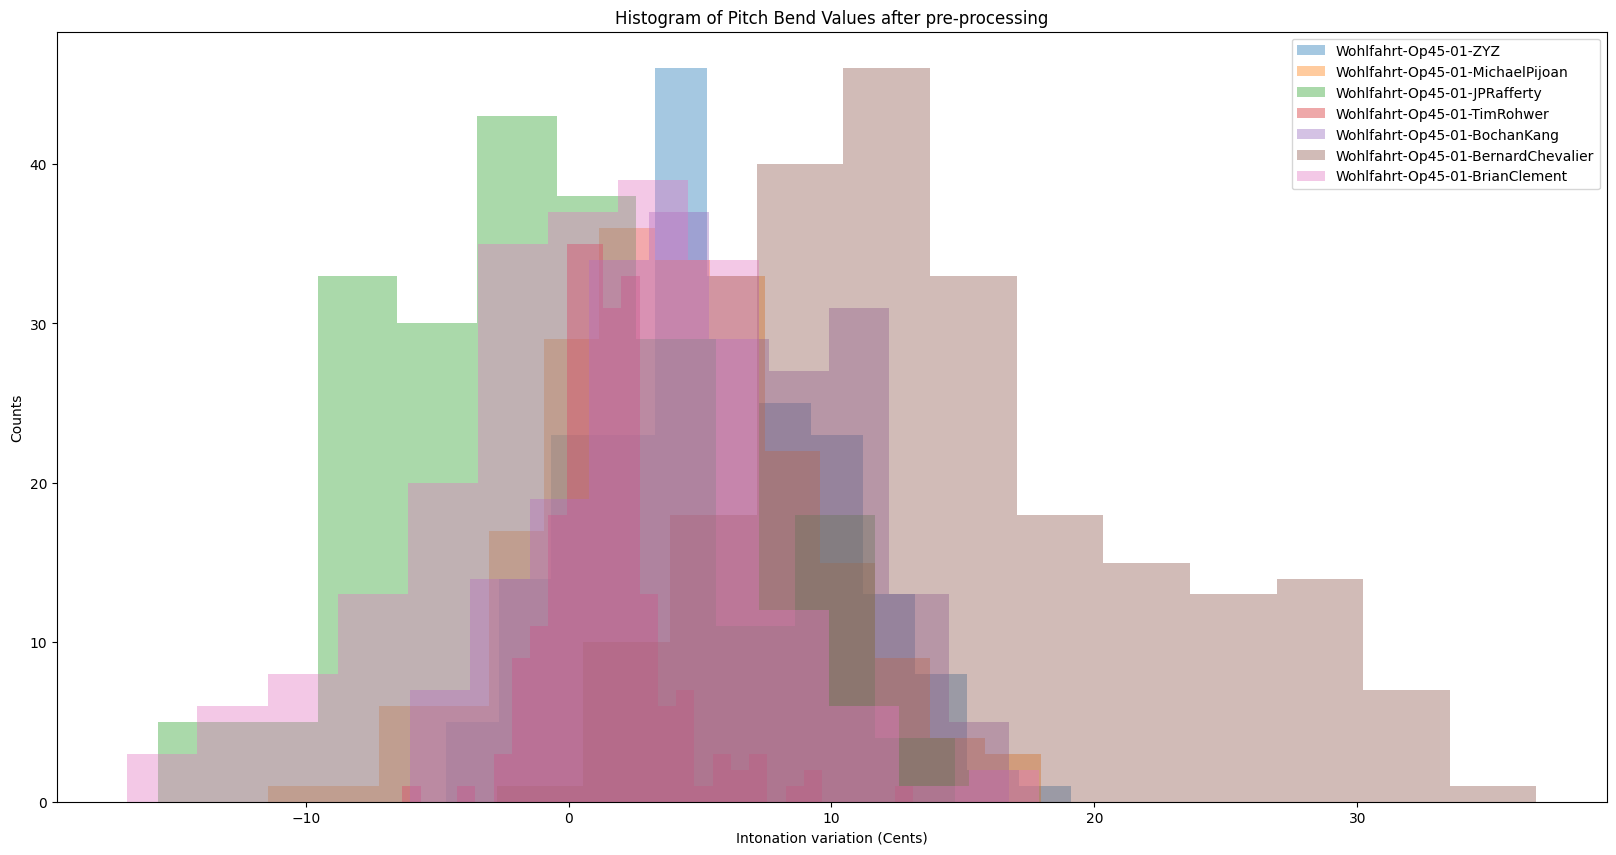

Mean of the data in the histogram: -0.9005402567719462
The following values are outliers: []
Key: Wohlfahrt-Op45-15-BochanKang
Outlier values: [-11.02294922  19.16503906  19.39318848]
Mean: 4.070856577054716
Standard Deviation: 4.982428983332136
Outlier keys: [177, 407, 495]
----------------------------------------
Key: Wohlfahrt-Op45-15-MichaelPijoan
Outlier values: [-18.44193522 -28.67431641 -19.23828125]
Mean: 3.058119090003202
Standard Deviation: 6.058523003696373
Outlier keys: [128, 210, 464]
----------------------------------------
Key: Wohlfahrt-Op45-15-ZYZ
Outlier values: [18.15600586]
Mean: 4.522131947607385
Standard Deviation: 4.135024678418683
Outlier keys: [480]
----------------------------------------
Key: Wohlfahrt-Op45-15-TimRohwer
Outlier values: [16.15478516 15.02807617 15.03662109]
Mean: -1.7927862019761964
Standard Deviation: 5.4289051498500855
Outlier keys: [305, 452, 453]
----------------------------------------
Key: Wohlfahrt-Op45-15-BrianClement
Outlier values: [

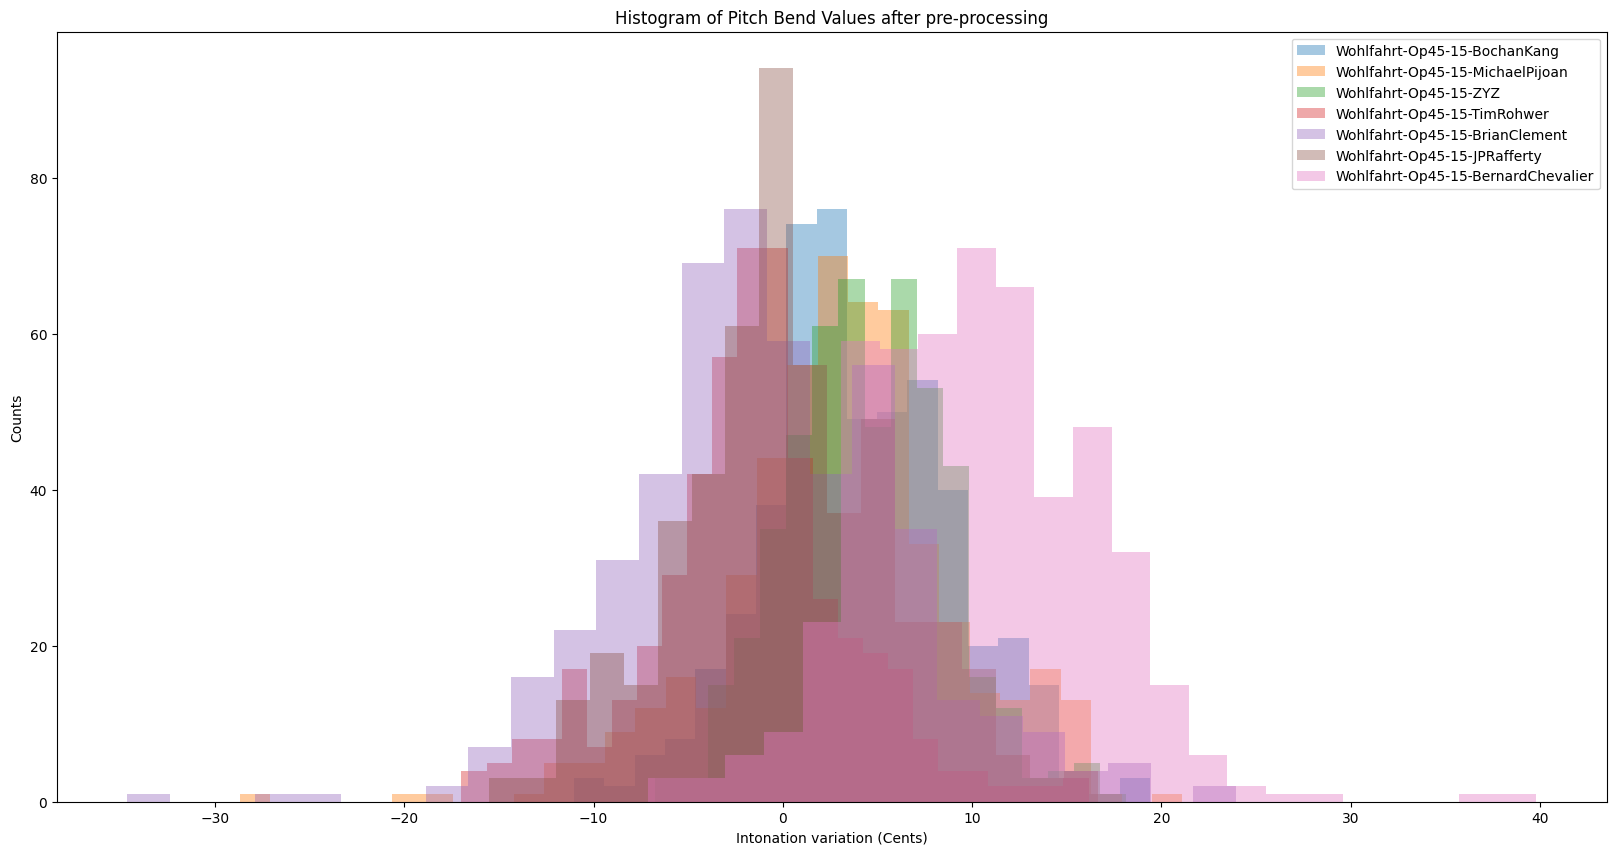

Mean of the data in the histogram: 9.263646252028607
The following values are outliers: [29.20092773 39.82089844 37.08129883]
Key: Wohlfahrt-Op45-03-ZYZ
Outlier values: [-10.65917969]
Mean: 5.66140094502437
Standard Deviation: 5.076428934818403
Outlier keys: [171]
----------------------------------------
Key: Wohlfahrt-Op45-03-MichaelPijoan
Outlier values: [-12.72631836  27.56054688 -12.02392578]
Mean: 4.979912585535708
Standard Deviation: 5.494897584906679
Outlier keys: [12, 78, 127]
----------------------------------------


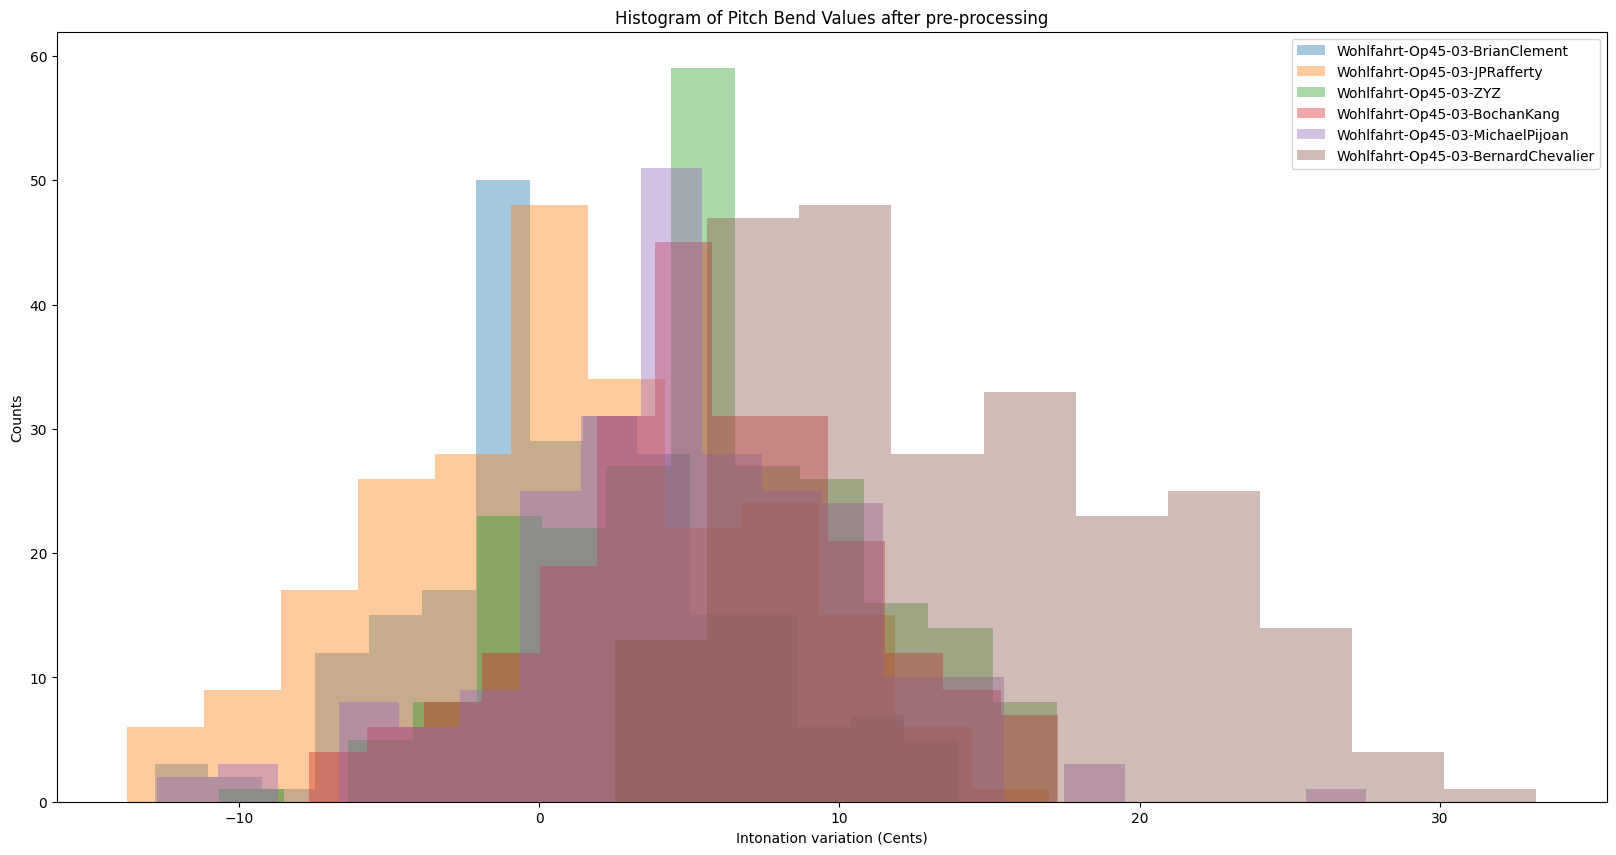

Mean of the data in the histogram: 12.448133358712923
The following values are outliers: []
Key: Wohlfahrt-Op45-26-JPRafferty
Outlier values: [-16.74211775 -15.96679688]
Mean: 1.3851666814855668
Standard Deviation: 4.640388217866244
Outlier keys: [0, 114]
----------------------------------------
Key: Wohlfahrt-Op45-26-MichaelPijoan
Outlier values: [24.08868963 26.14272837]
Mean: 6.063363316149623
Standard Deviation: 5.794967357865267
Outlier keys: [176, 227]
----------------------------------------
Key: Wohlfahrt-Op45-26-TimRohwer
Outlier values: [-32.81396484]
Mean: -1.116671629497363
Standard Deviation: 4.776761719754328
Outlier keys: [0]
----------------------------------------
Key: Wohlfahrt-Op45-26-ZYZ
Outlier values: [-5.22773437 -5.15136719]
Mean: 8.057218373777902
Standard Deviation: 4.230871469710448
Outlier keys: [75, 229]
----------------------------------------


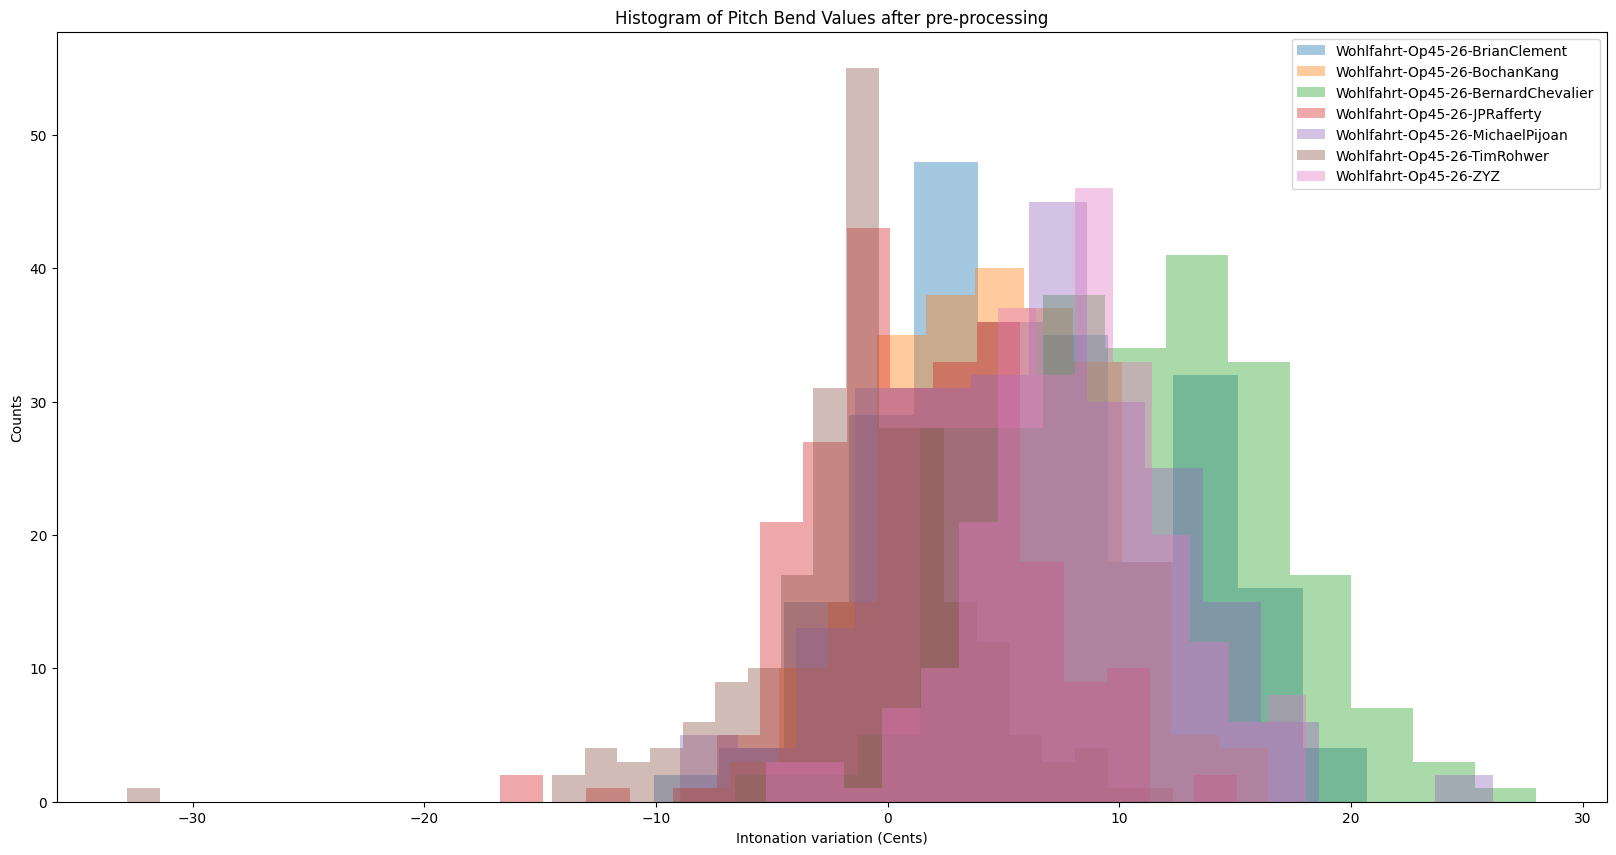

Mean of the data in the histogram: 7.224134825748095
The following values are outliers: [-5.22773437 -5.15136719]
Key: Wohlfahrt-Op45-05-MichaelPijoan
Outlier values: [28.65856934 26.96972656]
Mean: 5.402799774368763
Standard Deviation: 6.4900018329852625
Outlier keys: [27, 45]
----------------------------------------
Key: Wohlfahrt-Op45-05-BochanKang
Outlier values: [18.4039917]
Mean: 3.0668221008495946
Standard Deviation: 4.786689200006728
Outlier keys: [150]
----------------------------------------
Key: Wohlfahrt-Op45-05-JPRafferty
Outlier values: [16.23657227]
Mean: -0.7952298454239766
Standard Deviation: 5.269003410514504
Outlier keys: [108]
----------------------------------------
Key: Wohlfahrt-Op45-05-TimRohwer
Outlier values: [-14.42529297 -14.16113281]
Mean: 3.7947601177725376
Standard Deviation: 5.314519473506146
Outlier keys: [148, 160]
----------------------------------------
Key: Wohlfahrt-Op45-05-BrianClement
Outlier values: [-18.00048828]
Mean: -0.2178581516936382
Stand

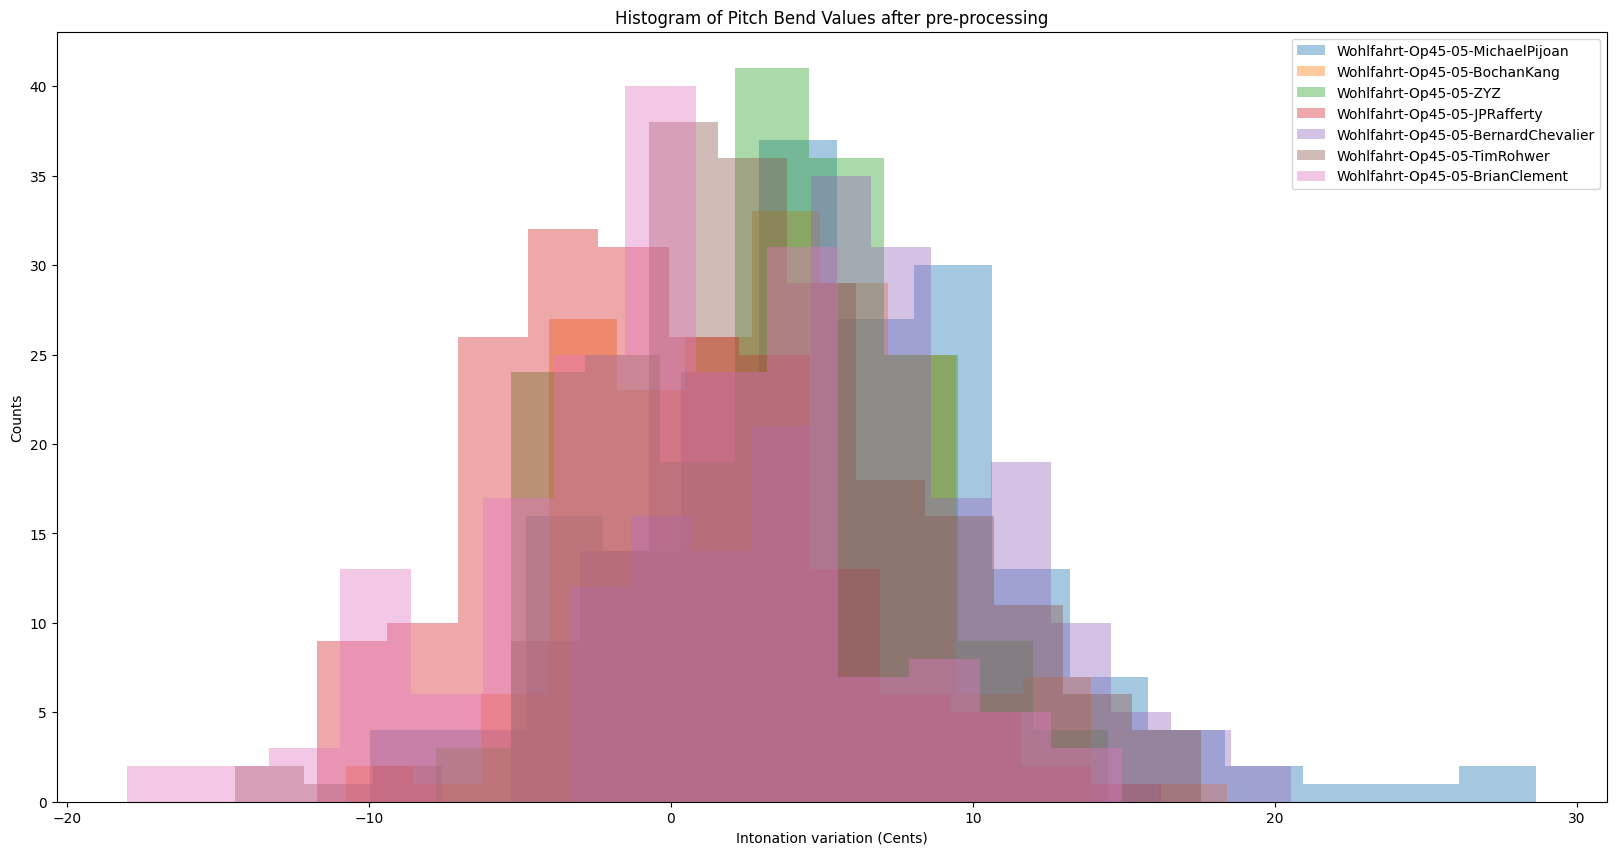

Mean of the data in the histogram: -1.3842644054219446
The following values are outliers: [-18.00048828]
Key: Wohlfahrt-Op45-11-BernardChevalier
Outlier values: [34.8046875  32.59814453]
Mean: 12.19647599087763
Standard Deviation: 6.10359039400125
Outlier keys: [150, 208]
----------------------------------------
Key: Wohlfahrt-Op45-11-JPRafferty
Outlier values: [13.73803711]
Mean: -2.449693216317039
Standard Deviation: 5.31307275264457
Outlier keys: [159]
----------------------------------------
Key: Wohlfahrt-Op45-11-TimRohwer
Outlier values: [14.91748047 13.62890625]
Mean: -4.459817282240881
Standard Deviation: 5.888041387734315
Outlier keys: [29, 125]
----------------------------------------
Key: Wohlfahrt-Op45-11-MichaelPijoan
Outlier values: [20.02514648]
Mean: 2.401465555756327
Standard Deviation: 5.789249488855708
Outlier keys: [126]
----------------------------------------


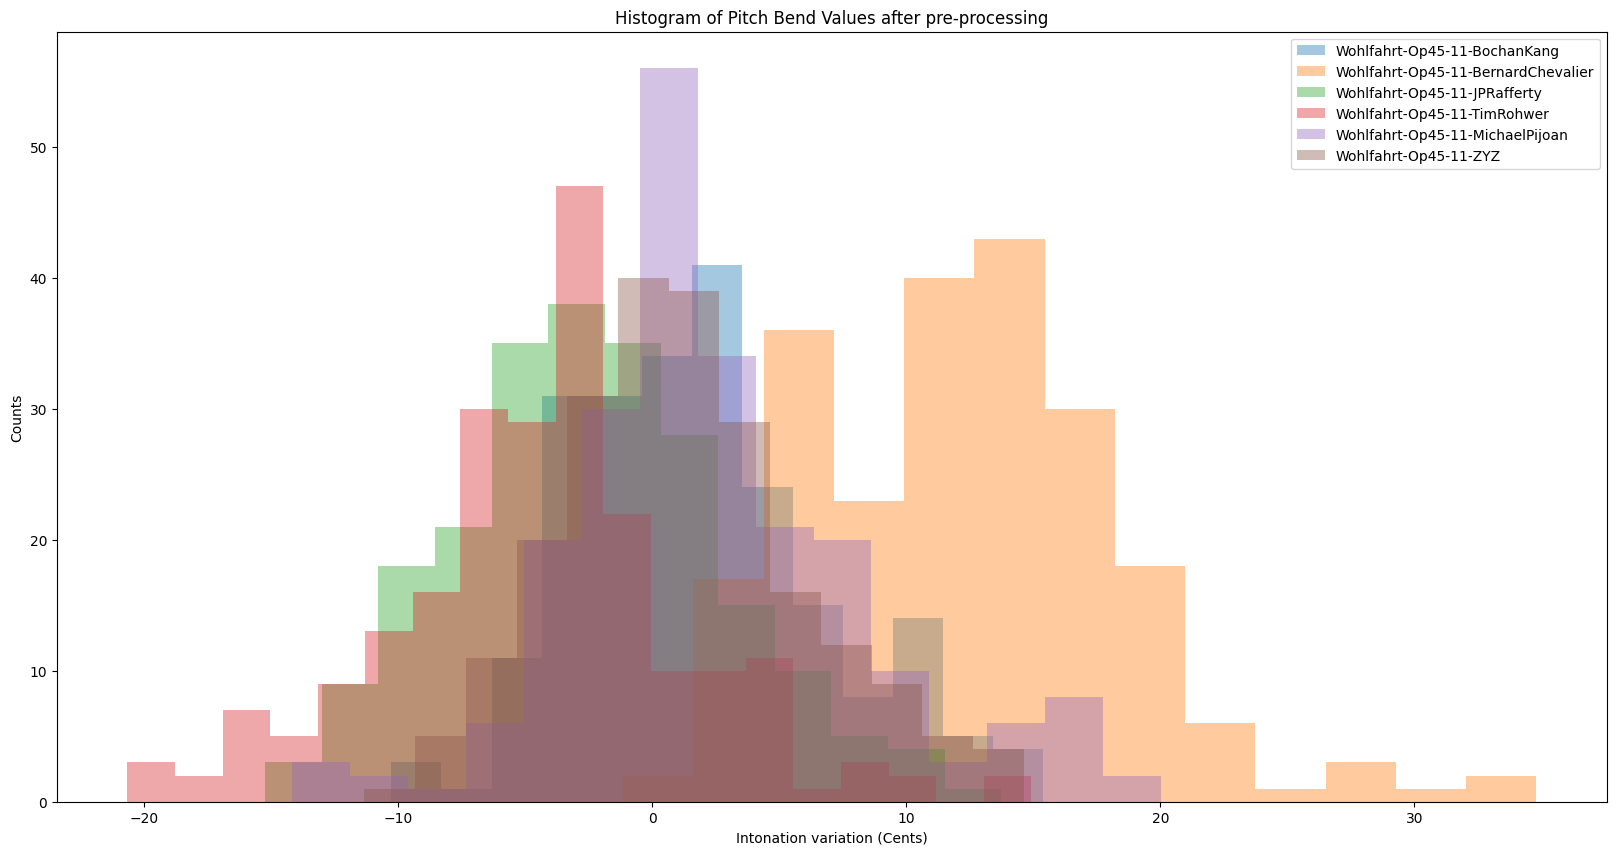

Mean of the data in the histogram: 0.146056240660733
The following values are outliers: []
Key: Wohlfahrt-Op45-10-JPRafferty
Outlier values: [21.95068359]
Mean: 4.2879356251313325
Standard Deviation: 5.684069637855216
Outlier keys: [25]
----------------------------------------


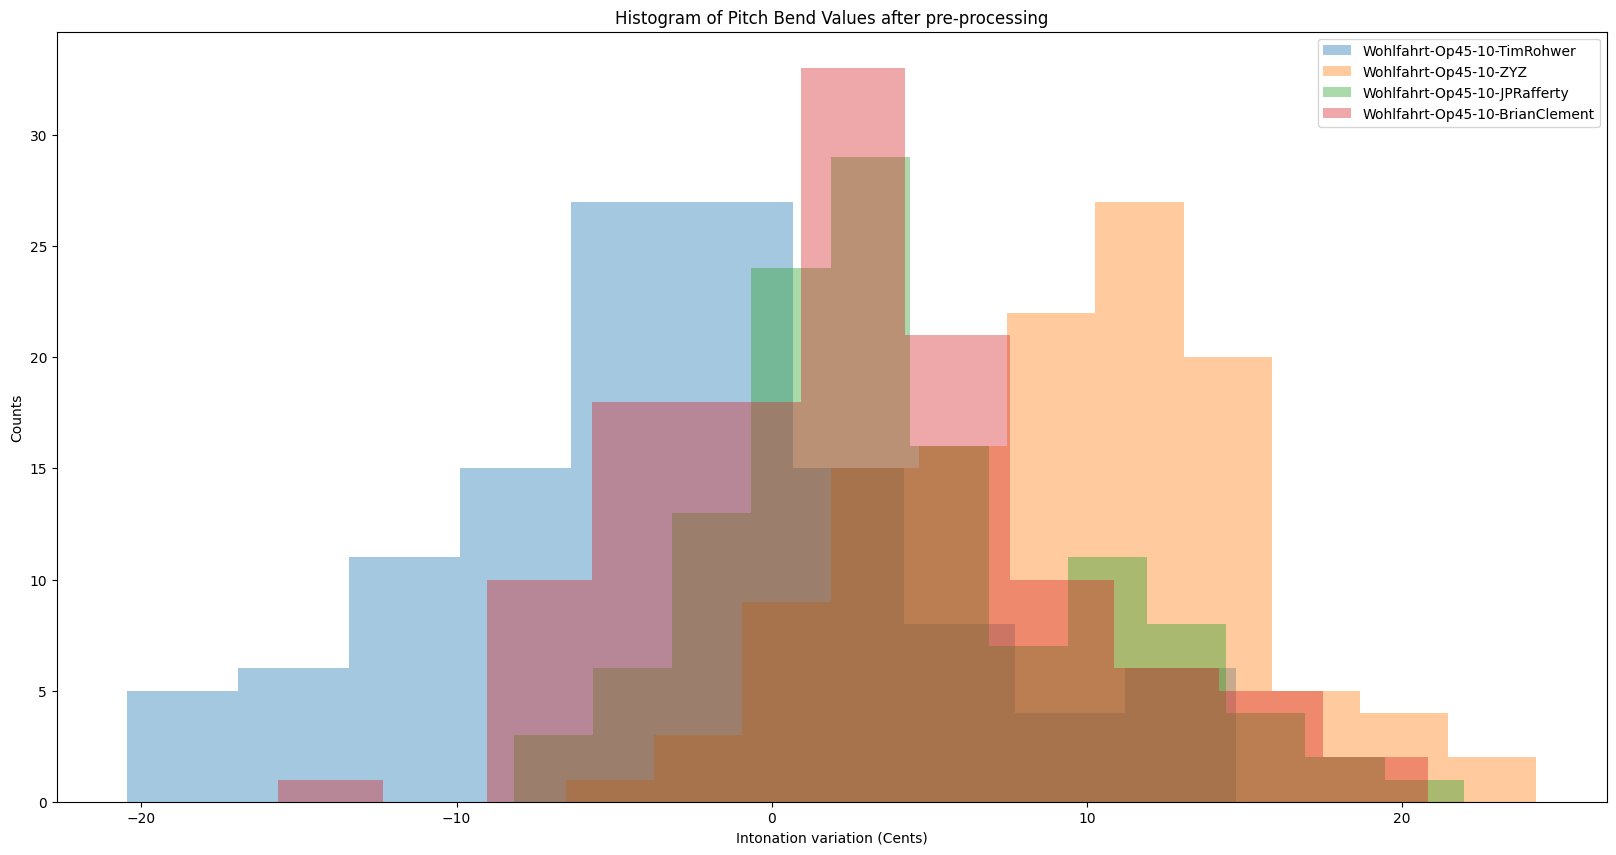

Mean of the data in the histogram: 0.9148245146780322
The following values are outliers: []


In [11]:
filtered_dict_c_n1 = dict_functions.filter_and_display(pshort_main_pitch_value, 'Wohlfahrt-Op45-01', plot_yes=True)
filtered_dict_c_n15 = dict_functions.filter_and_display(pshort_main_pitch_value, 'Wohlfahrt-Op45-15', plot_yes=True)

filtered_dict_g_n3 = dict_functions.filter_and_display(pshort_main_pitch_value, 'Wohlfahrt-Op45-03', plot_yes=True)
filtered_dict_g_n26 = dict_functions.filter_and_display(pshort_main_pitch_value, 'Wohlfahrt-Op45-26', plot_yes=True)

filtered_dict_f_n5 = dict_functions.filter_and_display(pshort_main_pitch_value, 'Wohlfahrt-Op45-05', plot_yes=True)
filtered_dict_eb_n11 = dict_functions.filter_and_display(pshort_main_pitch_value, 'Wohlfahrt-Op45-11', plot_yes=True)

filtered_dict_a_n10 = dict_functions.filter_and_display(pshort_main_pitch_value, 'Wohlfahrt-Op45-10', plot_yes=True)

In [12]:
pshort_dict_tonalities_players = {}
df_value_counts=pd.DataFrame()
df_value_counts_tonality = pd.DataFrame()

for element in tonalities_etudes.keys():
    filtered_dict_eb_n11 = dict_functions.filter_and_display(pshort_main_pitch_value, element, plot_yes=False)

    merged_df_eb_n11, names_new_columns = dict_functions.df_all_players_etude(filtered_dict_eb_n11, pdf_dict_short)
    tonalitys_grades = tonalities_etudes_notetoGrades[element]

    for index, note in enumerate(merged_df_eb_n11['pitch']):
        if '#' in note:
            full_note = note[:2]
        else:
            full_note = note[0]

        if full_note in tonalitys_grades.keys():
            new_note = tonalitys_grades[full_note]
            merged_df_eb_n11.loc[index, 'note_grade'] = new_note

    value_counts = merged_df_eb_n11['note_grade'].value_counts()
    df_value_counts[element] = value_counts

    current_tonality = tonalities_etudes[element]
    if current_tonality in pshort_dict_tonalities_players.keys():
        mean_data = merged_df_eb_n11.groupby('note_grade')[names_new_columns].mean()
        existing_data = pshort_dict_tonalities_players[current_tonality]

        updated_mean_data = (mean_data + existing_data) / 2
        pshort_dict_tonalities_players[current_tonality].update(updated_mean_data)

    else:
        pshort_dict_tonalities_players[current_tonality] = merged_df_eb_n11.groupby('note_grade')[names_new_columns].mean()

    if current_tonality in df_value_counts_tonality.keys():
        existing_data = df_value_counts_tonality[current_tonality]
        updated_value_counts = (value_counts + existing_data)
        df_value_counts_tonality[current_tonality].update(updated_value_counts)
    else:
        df_value_counts_tonality[current_tonality] = value_counts

print('Relationship between the number of notes per scale degree for all etudes and tonalities')
sorted_df_value_counts = df_value_counts.sort_index()
display(sorted_df_value_counts)

sorted_df_value_counts_tonality = df_value_counts_tonality.sort_index()
display(sorted_df_value_counts_tonality)

main_table = pd.DataFrame()
main_table_std = pd.DataFrame()
median_table = pd.DataFrame()
other_table = pd.DataFrame()
for current_tonality in pshort_dict_tonalities_players.keys():
    tonality_df = pshort_dict_tonalities_players[current_tonality]
    mean_values_per_row = tonality_df.mean(axis=1)
    std_per_row = tonality_df.std(axis=1)
    median_per_row = tonality_df.median(axis=1)
    main_table[current_tonality] = mean_values_per_row
    main_table_std[current_tonality] = std_per_row
    median_table[current_tonality] = median_per_row

    formatted_mean_values = mean_values_per_row.apply(lambda x: f"{x:.3f}")
    formatted_std_values = std_per_row.apply(lambda x: f"± {x:.3f}")
    formatted_median_values = median_per_row.apply(lambda x: f"{x:.3f}")

    mean_std_combined = formatted_mean_values + ' ' + formatted_std_values
    other_table[current_tonality] = mean_std_combined


cm = sns.light_palette("green", as_cmap=True)
cm1 = sns.light_palette("red", as_cmap=True)
cm2 = sns.light_palette("yellow", as_cmap=True)
pdf_to_see = main_table.T
pdf_std = main_table_std.T
pother_df = other_table.T
median_pdf = median_table.T

print(f'Trimming by peaks with histogram {overall_coverage_mean:.2f} % coverage mean')
print(f'Mean for every tonality, overall coverage mean {overall_coverage_mean:.2f}%')
display(pdf_to_see.style.background_gradient(cmap=cm, axis=1))

print(f'Median for every tonality, overall coverage mean {overall_coverage_mean:.2f}%')
display(median_pdf.style.background_gradient(cmap=cm, axis=1))

print(f'Std for every tonality, overall coverage mean {overall_coverage_mean:.2f}%')
display(pdf_std.style.background_gradient(cmap=cm1, axis=1))



print(f'Mean and Std for every tonality, overall coverage mean {overall_coverage_mean:.2f}% all short notes')
display(pother_df.style.background_gradient(cmap=cm2))


Relationship between the number of notes per scale degree for all etudes and tonalities


,Wohlfahrt-Op45-01,Wohlfahrt-Op45-03,Wohlfahrt-Op45-05,Wohlfahrt-Op45-10,Wohlfahrt-Op45-11,Wohlfahrt-Op45-15,Wohlfahrt-Op45-26
I,57,39,30,20,41,78,56
II,22,32,22,16,32,84,21
III,27,47,35,19,43,78,65
IV,13,35,28,19,26,62,16
V,34,39,29,19,35,68,60
VI,18,24,17,16,20,64,19
VII,45,20,25,15,23,70,2


,C,G,F,A,Eb
I,135,95,30,20,41
II,106,53,22,16,32
III,105,112,35,19,43
IV,75,51,28,19,26
V,102,99,29,19,35
VI,82,43,17,16,20
VII,115,22,25,15,23


Trimming by peaks with histogram 66.66 % coverage mean
Mean for every tonality, overall coverage mean 66.66%


note_grade,I,II,III,IV,V,VI,VII
C,1.142051,4.040260,5.936901,-0.196073,2.299040,4.039343,7.333063
G,3.298639,5.380434,9.283306,1.782160,4.815045,7.824137,8.810647
F,-0.256025,2.727324,5.182357,0.262420,2.567318,5.838695,5.435382
A,1.738048,0.064992,7.972293,1.689377,3.357158,3.003529,4.910767
Eb,-0.315022,-0.002358,4.891774,-0.023606,0.552104,4.776572,3.420110


Median for every tonality, overall coverage mean 66.66%


note_grade,I,II,III,IV,V,VI,VII
C,0.136043,4.321966,5.913401,0.233982,3.247991,3.846326,6.275305
G,3.059652,5.645053,7.348158,1.676897,6.003280,7.488212,7.514121
F,-0.913727,2.514331,5.039146,-0.452078,3.221474,5.615436,6.436950
A,2.801476,-0.406217,8.601329,1.557043,2.202645,1.672019,7.595493
Eb,-1.211451,-0.520060,5.441183,-0.715500,-0.091488,4.777595,2.571537


Std for every tonality, overall coverage mean 66.66%


note_grade,I,II,III,IV,V,VI,VII
C,4.801585,3.894220,5.169565,4.086679,3.656265,3.874403,7.391305
G,3.200665,3.372497,4.946067,5.222285,3.530617,3.431560,4.660084
F,3.763558,3.283584,2.527387,2.881636,3.066991,2.400945,4.185723
A,5.082764,6.710573,7.068788,3.461042,2.615491,6.433462,9.796497
Eb,4.914185,5.990381,7.040550,6.574437,5.341603,8.115903,4.134175


Mean and Std for every tonality, overall coverage mean 66.66% all short notes


note_grade,I,II,III,IV,V,VI,VII
C,1.142 ± 4.802,4.040 ± 3.894,5.937 ± 5.170,-0.196 ± 4.087,2.299 ± 3.656,4.039 ± 3.874,7.333 ± 7.391
G,3.299 ± 3.201,5.380 ± 3.372,9.283 ± 4.946,1.782 ± 5.222,4.815 ± 3.531,7.824 ± 3.432,8.811 ± 4.660
F,-0.256 ± 3.764,2.727 ± 3.284,5.182 ± 2.527,0.262 ± 2.882,2.567 ± 3.067,5.839 ± 2.401,5.435 ± 4.186
A,1.738 ± 5.083,0.065 ± 6.711,7.972 ± 7.069,1.689 ± 3.461,3.357 ± 2.615,3.004 ± 6.433,4.911 ± 9.796
Eb,-0.315 ± 4.914,-0.002 ± 5.990,4.892 ± 7.041,-0.024 ± 6.574,0.552 ± 5.342,4.777 ± 8.116,3.420 ± 4.134


### Tonality intonation study

{'C': 6.3453586263753525,
 'G': 5.93803926876789,
 'F': 4.937213127985273,
 'A': 7.081438457523265,
 'Eb': 7.076811969883904}

,STD_tonality_noSD
C,6.345359
G,5.938039
F,4.937213
A,7.081438
Eb,7.076812


<Axes: >

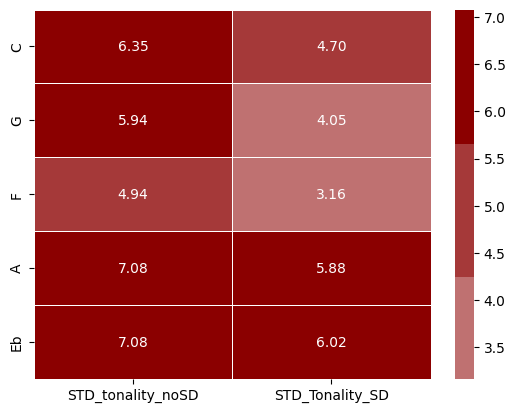

In [13]:
std_per_etude = {}
for element in tonalities_etudes.keys():
    filtered_dict_eb_n11 = dict_functions.filter_and_display(pshort_main_pitch_value, element, plot_yes=False)
    merged_df_eb_n11, names_new_columns = dict_functions.df_all_players_etude(filtered_dict_eb_n11, pdf_dict_short)
    # do the mean and std of the pitch columns for every note taking into account all the players
    selected_columns = merged_df_eb_n11.filter(like='pitchValue')
    mean_values = selected_columns.mean(axis=1)
    std_values = selected_columns.std(axis=1)
    # once you have the std of the values, you do the mean std across all the notes
    mean_std_values = std_values.mean()
    std_per_etude[element] = mean_std_values

tonality_std = {}
for key,value in std_per_etude.items():
    tonality = tonalities_etudes[key]
    #saves the tonality and the std of the etude, looking if the tonality already exists, if it does, it calculates the mean
    if tonality in tonality_std.keys():
        existing_data = tonality_std[tonality]
        updated_value = (value + existing_data)/2
        tonality_std[tonality] = updated_value
    else:
        tonality_std[tonality] = value
display(tonality_std)

main_tablestd_copy = main_table_std.T
main_tablestd_copy['RowSum'] = main_tablestd_copy.sum(axis=1)
main_tablestd_copy['STD_Mean_tonality'] = main_tablestd_copy.drop(columns=['RowSum']).mean(axis=1)
main_tablestd_copy_copy = main_tablestd_copy.drop(columns=['RowSum'])

tonality_std_df = pd.DataFrame.from_dict(tonality_std, orient='index', columns=['STD_tonality_noSD'])
display(tonality_std_df)
main_tablestd_copy_copy['STD_Mean_tonality']
# merge dfs
main_df_std = pd.merge(tonality_std_df, main_tablestd_copy_copy['STD_Mean_tonality'], left_index=True, right_index=True)
main_df_std.rename(columns={'STD_Mean_tonality': 'STD_Tonality_SD'}, inplace=True)


colors = ["darkblue", "white", "darkred"]
n_bins = 10  # Number of bins in the colormap
cmap_name = "custom_cmap"
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

sns.heatmap(main_df_std, annot=True, cmap=cm, fmt='.2f', linewidths=0.5, center=0)

## Direction

In [17]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
columns = ['note_grade', 'ascending', 'descending', 'First_Note', 'equal']
df_final = pd.DataFrame(columns=columns)
short_dict_tonalities_players = {}
std_dict_tonalities_players = {}

for element in tonalities_etudes.keys():
    filtered_dict = dict_functions.filter_and_display(pshort_main_pitch_value, element, plot_yes=False)

    merged_df, names_new_columns = dict_functions.df_all_players_etude(filtered_dict, pdf_dict_short)

    merged_df = dict_functions.define_direction_in_df(merged_df)
    tonalitys_grades = tonalities_etudes_notetoGrades[element]

    for index, note in enumerate(merged_df['pitch']):
        if '#' in note:
            full_note = note[:2]
        else:
            full_note = note[0]

        if full_note in tonalitys_grades.keys():
            new_note = tonalitys_grades[full_note]
            merged_df.loc[index, 'note_grade'] = new_note
        else:
            print(f'Note {full_note} not found in tonality {element}')
            print('index', index)
            print('note', note)
            display(merged_df.loc[index])



    current_tonality = tonalities_etudes[element]

    merged_df['direction'] = pd.Categorical(merged_df['direction'], categories=['Ascending', 'Descending', 'Equal'], ordered=False)

    if current_tonality in short_dict_tonalities_players.keys():
        current_df = short_dict_tonalities_players[current_tonality]
        short_dict_tonalities_players[current_tonality] = pd.concat([short_dict_tonalities_players[current_tonality], merged_df])

    else:
        short_dict_tonalities_players[current_tonality] = merged_df

tonality_series = {}
tonality_std_series = {}
tonality_median_series = {}

# MEAN
tonality_series_ascending = {}
tonality_series_descending = {}
tonality_series_equal = {}

# STD
tonality_std_series_ascending = {}
tonality_std_series_descending = {}
tonality_std_series_equal = {}

# MEDIAN
tonality_median_series_ascending = {}
tonality_median_series_descending = {}
tonality_median_series_equal = {}


# Iterate through each tonality
for current_tonality in short_dict_tonalities_players.keys():

    selected_columns = short_dict_tonalities_players[current_tonality].filter(like='pitchValue')
    selected_columns_mean = selected_columns.mean(axis=1)
    selected_columns_std = selected_columns.std(axis=1)
    selected_columns_median = selected_columns.median(axis=1)

    # MEAN
    tonality_series[current_tonality] = pd.DataFrame(selected_columns_mean)
    tonality_series[current_tonality].columns = ['mean pitch value']
    tonality_series[current_tonality]['note_grade'] = short_dict_tonalities_players[current_tonality]['note_grade']
    tonality_series[current_tonality]['pitch'] = short_dict_tonalities_players[current_tonality]['pitch']
    tonality_series[current_tonality]['direction'] = short_dict_tonalities_players[current_tonality]['direction']

    tonality_series_ascending[current_tonality] = tonality_series[current_tonality][tonality_series[current_tonality]['direction'] == 'Ascending']
    direction_columns_to_keep = [column for column in tonality_series_ascending[current_tonality].columns if 'direction' not in column or 'direction' not in column.lower()]
    tonality_series_ascending[current_tonality] = tonality_series_ascending[current_tonality][direction_columns_to_keep]

    tonality_series_descending[current_tonality] = tonality_series[current_tonality][tonality_series[current_tonality]['direction'] == 'Descending']
    direction_columns_to_keep = [column for column in tonality_series_ascending[current_tonality].columns if 'direction' not in column or 'direction' not in column.lower()]
    tonality_series_descending[current_tonality] = tonality_series_descending[current_tonality][direction_columns_to_keep]

    tonality_series_equal[current_tonality] = tonality_series[current_tonality][tonality_series[current_tonality]['direction'] == 'Equal']
    direction_columns_to_keep = [column for column in tonality_series_ascending[current_tonality].columns if 'direction' not in column or 'direction' not in column.lower()]
    tonality_series_equal[current_tonality] = tonality_series_equal[current_tonality][direction_columns_to_keep]


    # STD
    tonality_std_series[current_tonality] = pd.DataFrame(selected_columns_std)
    tonality_std_series[current_tonality].columns = ['std pitch value']
    tonality_std_series[current_tonality]['note_grade'] = short_dict_tonalities_players[current_tonality]['note_grade']
    tonality_std_series[current_tonality]['pitch'] = short_dict_tonalities_players[current_tonality]['pitch']
    tonality_std_series[current_tonality]['direction'] = short_dict_tonalities_players[current_tonality]['direction']

    tonality_std_series_ascending[current_tonality] = tonality_std_series[current_tonality][tonality_std_series[current_tonality]['direction'] == 'Ascending']
    direction_columns_to_keep_std = [column for column in tonality_std_series_ascending[current_tonality].columns if 'direction' not in column or 'direction' not in column.lower()]
    tonality_std_series_ascending[current_tonality] = tonality_std_series_ascending[current_tonality][direction_columns_to_keep_std]

    tonality_std_series_descending[current_tonality] = tonality_std_series[current_tonality][tonality_std_series[current_tonality]['direction'] == 'Descending']
    direction_columns_to_keep_std = [column for column in tonality_std_series_descending[current_tonality].columns if 'direction' not in column or 'direction' not in column.lower()]
    tonality_std_series_descending[current_tonality] = tonality_std_series_descending[current_tonality][direction_columns_to_keep_std]

    tonality_std_series_equal[current_tonality] = tonality_std_series[current_tonality][tonality_std_series[current_tonality]['direction'] == 'Equal']
    direction_columns_to_keep_std = [column for column in tonality_std_series_equal[current_tonality].columns if 'direction' not in column or 'direction' not in column.lower()]
    tonality_std_series_equal[current_tonality] = tonality_std_series_equal[current_tonality][direction_columns_to_keep_std]

    #MEDIAN
    tonality_median_series[current_tonality] = pd.DataFrame(selected_columns_median)
    tonality_median_series[current_tonality].columns = ['median pitch value']
    tonality_median_series[current_tonality]['note_grade'] = short_dict_tonalities_players[current_tonality]['note_grade']
    tonality_median_series[current_tonality]['pitch'] = short_dict_tonalities_players[current_tonality]['pitch']
    tonality_median_series[current_tonality]['direction'] = short_dict_tonalities_players[current_tonality]['direction']

    tonality_median_series_ascending[current_tonality] = tonality_median_series[current_tonality][tonality_median_series[current_tonality]['direction'] == 'Ascending']
    direction_columns_to_keep_median = [column for column in tonality_median_series_ascending[current_tonality].columns if 'direction' not in column or 'direction' not in column.lower()]
    tonality_median_series_ascending[current_tonality] = tonality_median_series_ascending[current_tonality][direction_columns_to_keep_median]

    tonality_median_series_descending[current_tonality] = tonality_median_series[current_tonality][tonality_median_series[current_tonality]['direction'] == 'Descending']
    direction_columns_to_keep_median = [column for column in tonality_median_series_descending[current_tonality].columns if 'direction' not in column or 'direction' not in column.lower()]
    tonality_median_series_descending[current_tonality] = tonality_median_series_descending[current_tonality][direction_columns_to_keep_median]

    tonality_median_series_equal[current_tonality] = tonality_median_series[current_tonality][tonality_median_series[current_tonality]['direction'] == 'Equal']
    direction_columns_to_keep_median = [column for column in tonality_median_series_equal[current_tonality].columns if 'direction' not in column or 'direction' not in column.lower()]
    tonality_median_series_equal[current_tonality] = tonality_median_series_equal[current_tonality][direction_columns_to_keep_median]



    tonality_series[current_tonality] =  tonality_series[current_tonality].groupby(['note_grade', 'direction']).mean()
    tonality_std_series[current_tonality] = tonality_series[current_tonality].groupby(['note_grade', 'direction']).mean()
    tonality_series_ascending[current_tonality] = tonality_series_ascending[current_tonality].groupby(['note_grade']).mean()
    tonality_series_descending[current_tonality] = tonality_series_descending[current_tonality].groupby(['note_grade']).mean()
    tonality_series_equal[current_tonality] = tonality_series_equal[current_tonality].groupby(['note_grade']).mean()

    tonality_std_series_ascending[current_tonality] = tonality_std_series_ascending[current_tonality].groupby(['note_grade']).mean()
    tonality_std_series_descending[current_tonality] = tonality_std_series_descending[current_tonality].groupby(['note_grade']).mean()
    tonality_std_series_equal[current_tonality] = tonality_std_series_equal[current_tonality].groupby(['note_grade']).mean()

    tonality_median_series[current_tonality] = tonality_median_series[current_tonality].groupby(['note_grade', 'direction']).mean()
    tonality_median_series_ascending[current_tonality] = tonality_median_series_ascending[current_tonality].groupby(['note_grade']).mean()
    tonality_median_series_descending[current_tonality] = tonality_median_series_descending[current_tonality].groupby(['note_grade']).mean()
    tonality_median_series_equal[current_tonality] = tonality_median_series_equal[current_tonality].groupby(['note_grade']).mean()


main_table = pd.concat(tonality_series, axis=1)
main_table_std = pd.concat(tonality_std_series, axis=1)
main_table_median = pd.concat(tonality_median_series, axis=1)


main_ascending = pd.concat(tonality_series_ascending, axis=1)
main_descending = pd.concat(tonality_series_descending, axis=1)
main_equal = pd.concat(tonality_series_equal, axis=1)

main_ascending_std = pd.concat(tonality_std_series_ascending, axis=1)
main_descending_std = pd.concat(tonality_std_series_descending, axis=1)
main_equal_std = pd.concat(tonality_std_series_equal, axis=1)

main_median_ascending = pd.concat(tonality_median_series_ascending, axis=1)
main_median_descending = pd.concat(tonality_median_series_descending, axis=1)
main_median_equal = pd.concat(tonality_median_series_equal, axis=1)

cm = sns.light_palette("green", as_cmap=True)
cm1 = sns.light_palette("red", as_cmap=True)
cm2 = sns.light_palette("blue", as_cmap=True)
cm3 = sns.light_palette("yellow", as_cmap=True)


display(main_ascending.T.style.background_gradient(cmap=cm1, axis=1))
display(main_descending.T.style.background_gradient(cmap=cm2, axis=1))
display(main_equal.T.style.background_gradient(cmap=cm3, axis=1))

display(main_ascending_std.T.style.background_gradient(cmap=cm1, axis=1))
display(main_descending_std.T.style.background_gradient(cmap=cm2, axis=1))
display(main_equal_std.T.style.background_gradient(cmap=cm3, axis=1))

display(main_median_ascending.T.style.background_gradient(cmap=cm1, axis=1))
display(main_median_descending.T.style.background_gradient(cmap=cm2, axis=1))
display(main_median_equal.T.style.background_gradient(cmap=cm3, axis=1))

,note_grade,I,II,III,IV,V,VI,VII
C,mean pitch value,0.950711,3.623052,6.345310,0.225943,2.103422,4.809192,6.361888
G,mean pitch value,2.269370,5.814460,8.336721,0.663153,4.594014,7.889605,8.432747
F,mean pitch value,0.050646,1.917933,4.597078,1.158105,3.145356,6.756104,5.840876
A,mean pitch value,2.159897,-0.962637,9.496660,1.764858,7.007637,3.741418,3.250861
Eb,mean pitch value,1.552606,0.556557,4.707823,-0.257847,1.371879,4.719830,2.404260


,note_grade,I,II,III,IV,V,VI,VII,#IV
C,mean pitch value,1.023956,3.552126,5.432395,-0.971521,2.189501,1.970447,8.165640,nan
G,mean pitch value,3.140611,3.607428,8.372761,2.215102,4.345613,6.319519,10.121212,nan
F,mean pitch value,-0.524362,3.287671,5.621317,-1.121821,1.668164,4.806610,5.116780,nan
A,mean pitch value,1.392898,1.092621,7.565796,1.559982,2.383697,2.265640,6.232752,nan
Eb,mean pitch value,-1.396957,-0.337707,5.124133,0.148170,-0.315894,4.814401,3.778645,3.989588


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,note_grade,I,II,III,IV,V,VI,VII
C,mean pitch value,1.453473,3.241297,4.919350,0.006911,1.904207,2.225338,5.749331
G,mean pitch value,nan,nan,nan,nan,nan,nan,nan
F,mean pitch value,nan,nan,nan,nan,nan,nan,nan
A,mean pitch value,nan,nan,nan,nan,nan,nan,nan
Eb,mean pitch value,nan,nan,nan,nan,nan,nan,nan


,note_grade,I,II,III,IV,V,VI,VII
C,std pitch value,6.342768,6.181387,6.278217,5.646717,5.604685,6.261444,7.993629
G,std pitch value,5.743899,5.266182,6.944760,6.744955,5.908951,5.638802,7.337078
F,std pitch value,5.286646,6.204083,5.718522,4.711326,5.715351,4.423940,4.911778
A,std pitch value,6.828015,9.115665,7.536864,4.549067,4.624614,6.337926,8.837479
Eb,std pitch value,6.566904,6.359894,8.795698,7.433575,6.908527,9.068046,4.615572


,note_grade,I,II,III,IV,V,VI,VII,#IV
C,std pitch value,6.493810,4.952160,6.082429,6.077418,5.409463,4.834497,8.731166,nan
G,std pitch value,5.794930,3.730905,6.546714,7.042882,5.124410,4.367386,7.205258,nan
F,std pitch value,5.640683,5.022834,4.038213,4.007404,4.615712,3.451621,5.069383,nan
A,std pitch value,6.532444,6.293423,8.501790,5.701595,4.983483,7.936635,11.412352,nan
Eb,std pitch value,6.146572,7.259592,7.630436,8.542260,5.242853,9.632660,5.464516,2.020846


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,note_grade,I,II,III,IV,V,VI,VII
C,std pitch value,6.791940,5.133311,6.019490,5.733805,5.631635,5.703798,8.010408
G,std pitch value,nan,nan,nan,nan,nan,nan,nan
F,std pitch value,nan,nan,nan,nan,nan,nan,nan
A,std pitch value,nan,nan,nan,nan,nan,nan,nan
Eb,std pitch value,nan,nan,nan,nan,nan,nan,nan


,note_grade,I,II,III,IV,V,VI,VII
C,median pitch value,0.659790,3.746155,6.390851,-0.224102,1.650732,4.604199,5.169359
G,median pitch value,1.989409,5.339383,7.112101,-0.344443,5.013955,7.853387,7.958276
F,median pitch value,-0.442418,2.433165,4.758461,1.107151,3.687272,6.423914,6.269206
A,median pitch value,2.045678,-1.126293,10.514579,1.788151,5.986404,2.761874,3.896623
Eb,median pitch value,1.062019,-0.309010,4.035165,-1.483201,0.479641,3.735781,1.772987


,note_grade,I,II,III,IV,V,VI,VII,#IV
C,median pitch value,1.388133,3.521236,5.778306,-0.578853,1.947774,1.772640,7.165634,nan
G,median pitch value,3.211554,4.078023,8.196172,1.593953,4.448379,5.742456,9.766897,nan
F,median pitch value,0.374736,3.039359,5.903137,-1.660190,1.916724,4.596640,5.147911,nan
A,median pitch value,1.835724,0.094710,8.518618,1.409610,2.036605,1.338639,8.945143,nan
Eb,median pitch value,-2.185031,-0.556312,4.782548,-0.808219,-0.769220,4.751670,3.581063,3.558547


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,note_grade,I,II,III,IV,V,VI,VII
C,median pitch value,1.210267,3.555810,5.074424,-0.468178,2.529748,2.643003,5.649915
G,median pitch value,nan,nan,nan,nan,nan,nan,nan
F,median pitch value,nan,nan,nan,nan,nan,nan,nan
A,median pitch value,nan,nan,nan,nan,nan,nan,nan
Eb,median pitch value,nan,nan,nan,nan,nan,nan,nan


## Mean Direction

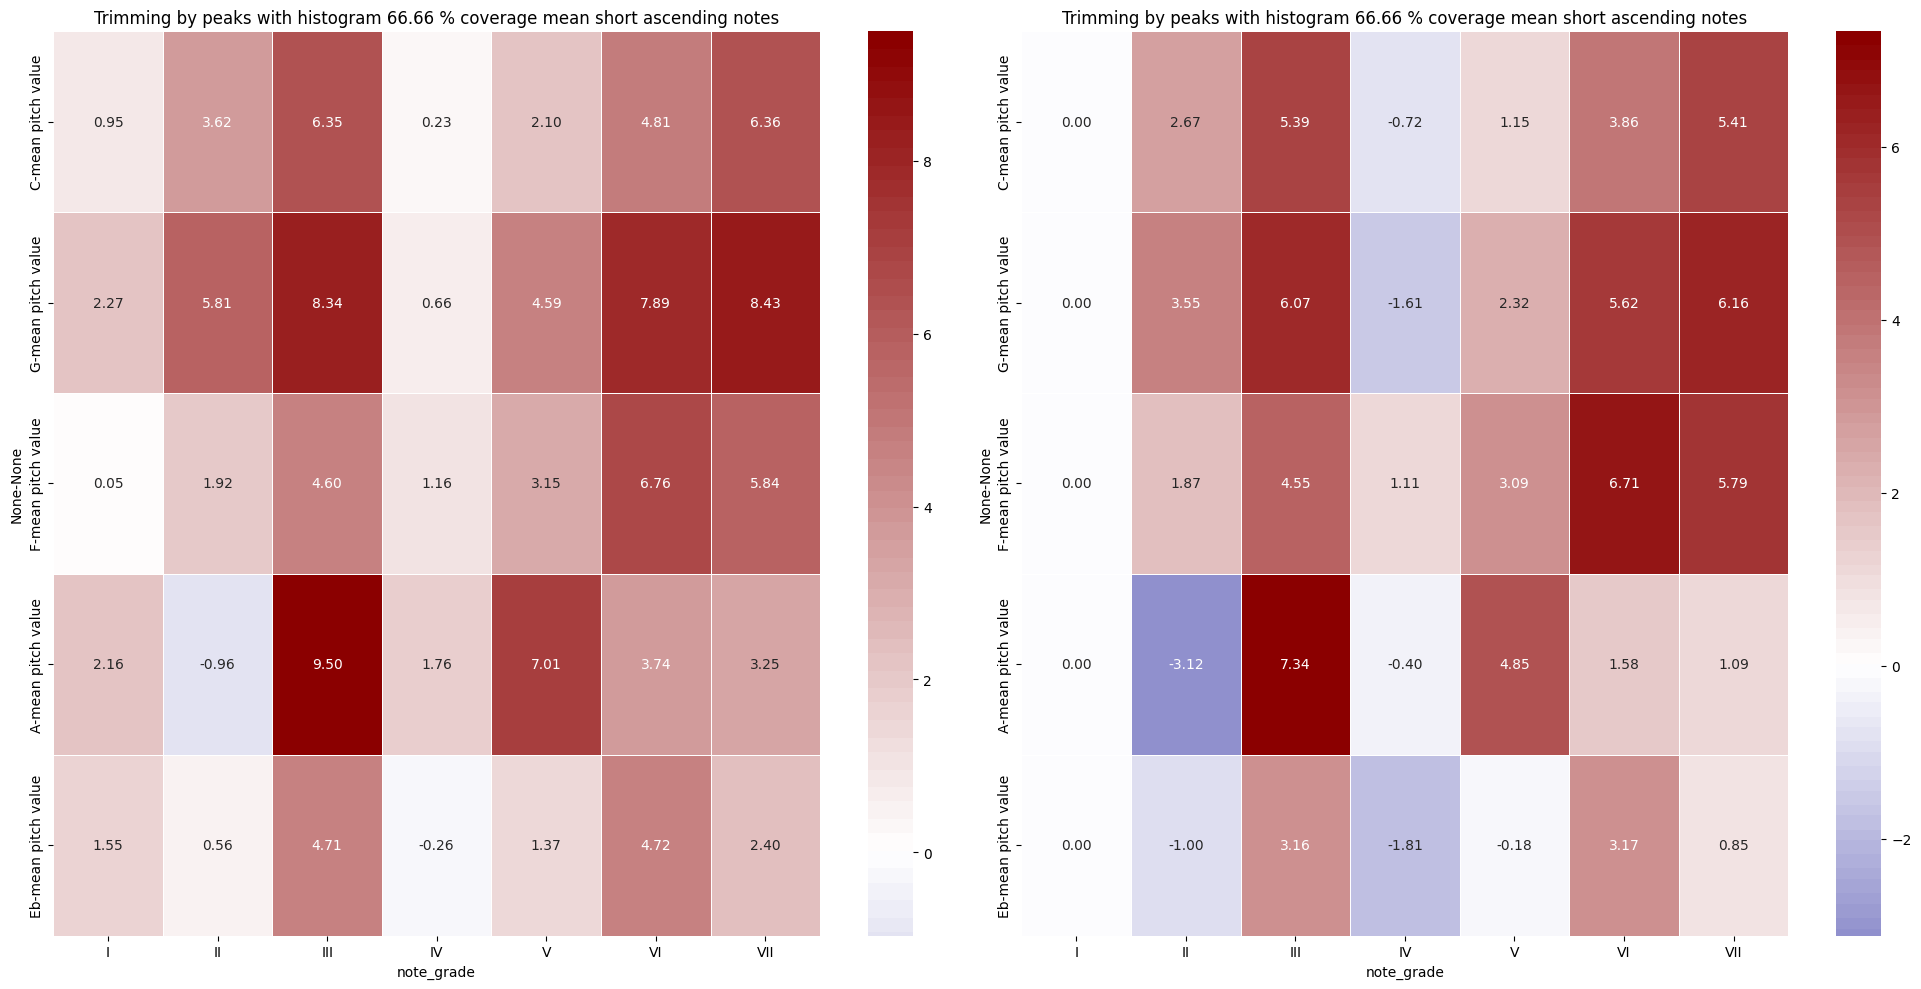

In [18]:
dict_functions.see_heatmap_zero_tonic(main_ascending, 'ascending', overall_coverage_mean)

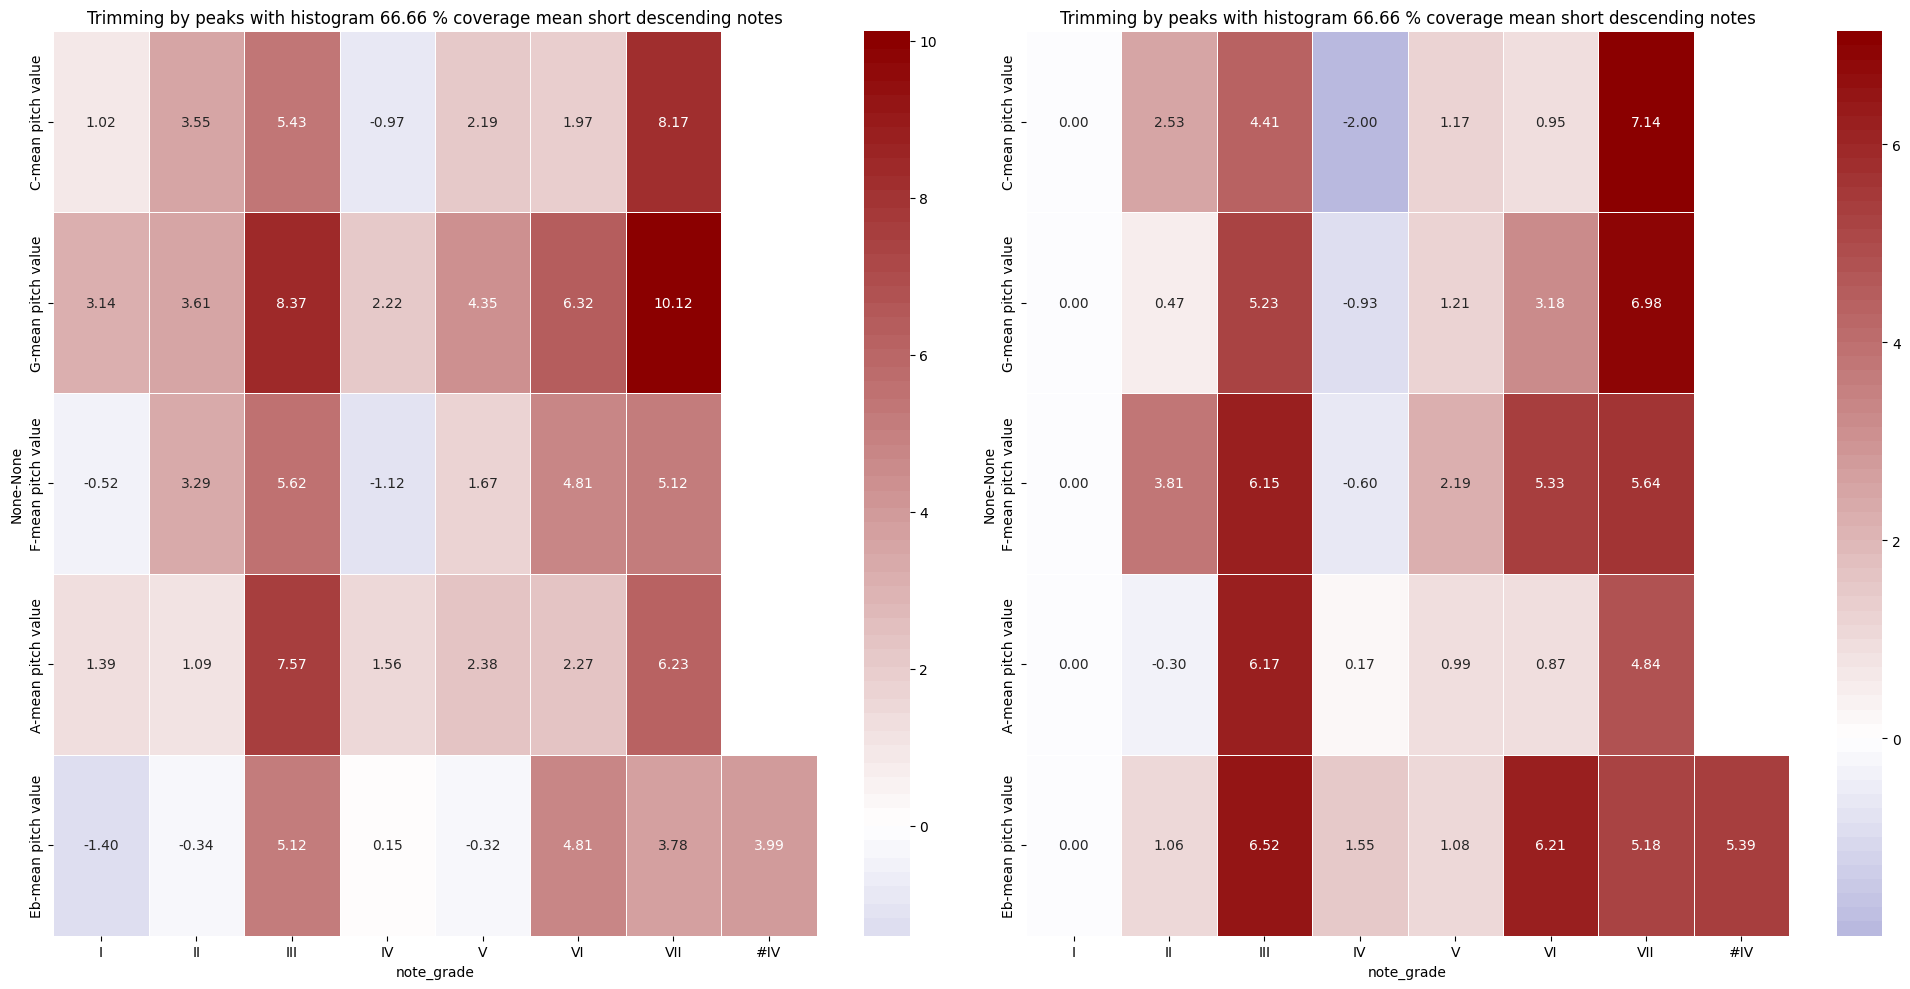

In [19]:
dict_functions.see_heatmap_zero_tonic(main_descending, 'descending', overall_coverage_mean)

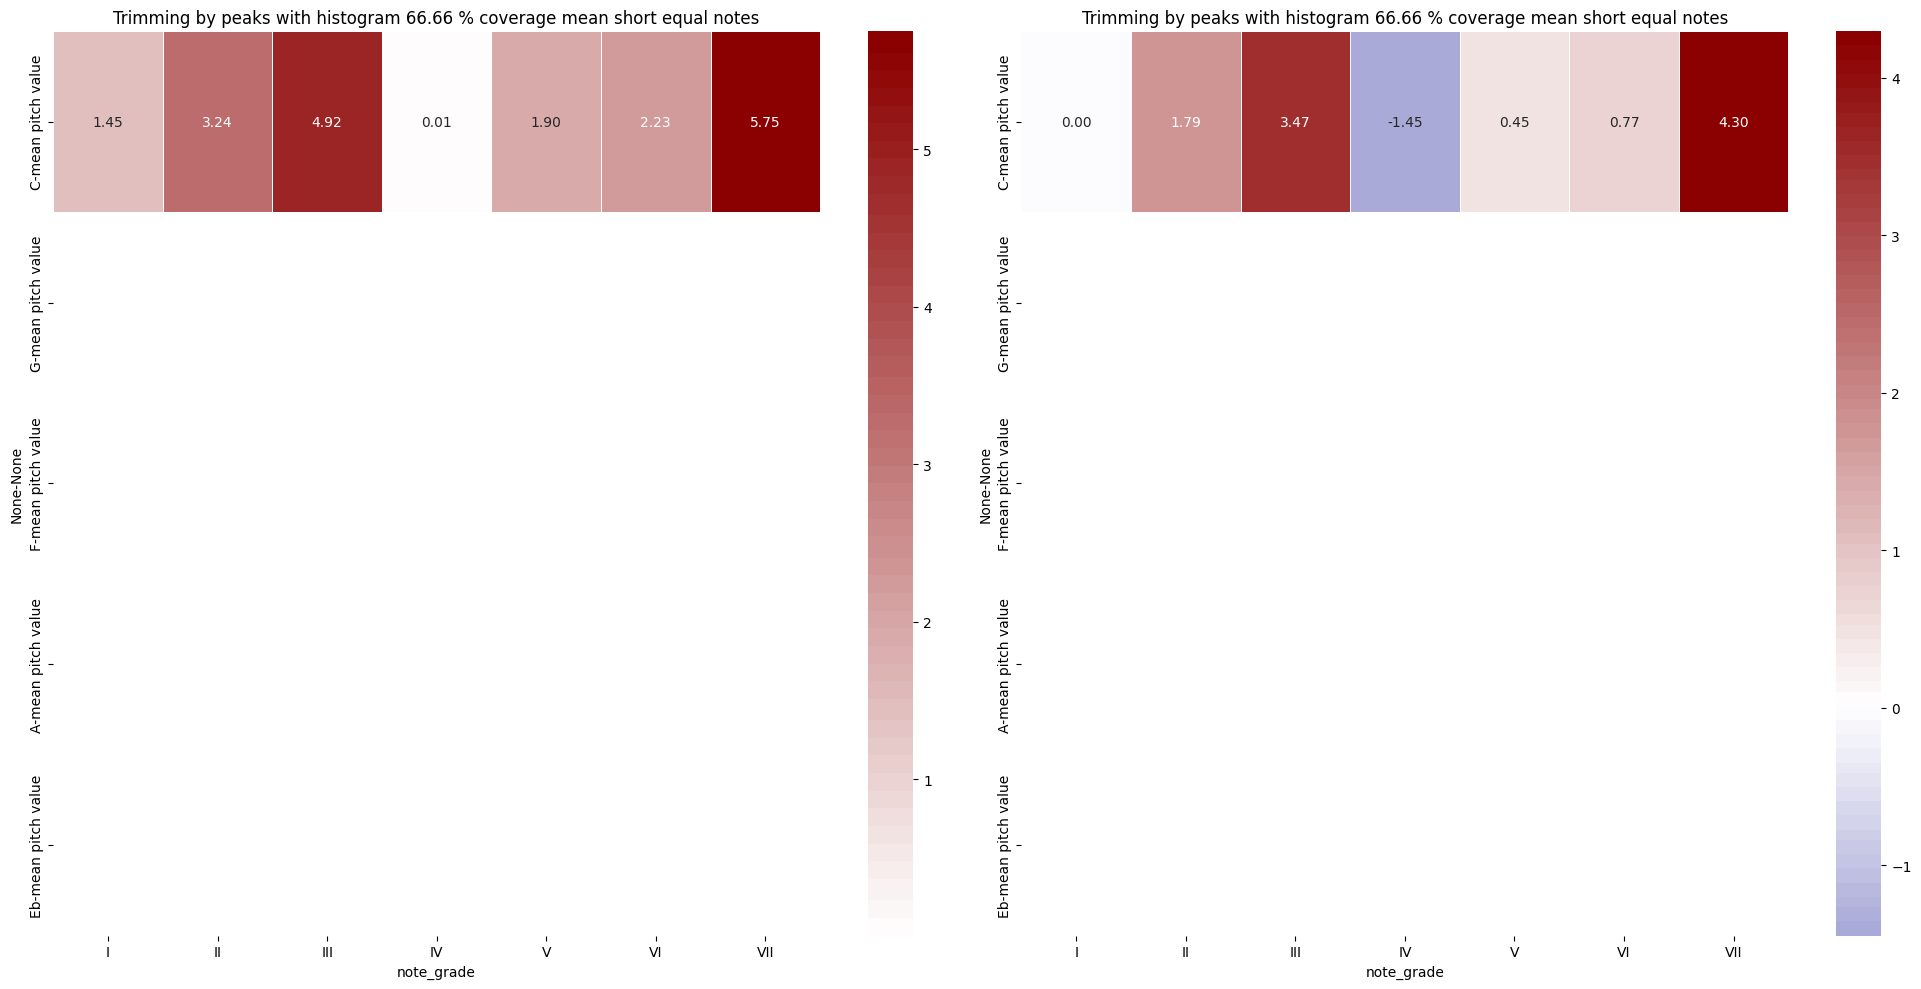

In [20]:
dict_functions.see_heatmap_zero_tonic(main_equal, 'equal', overall_coverage_mean)

## STD direction

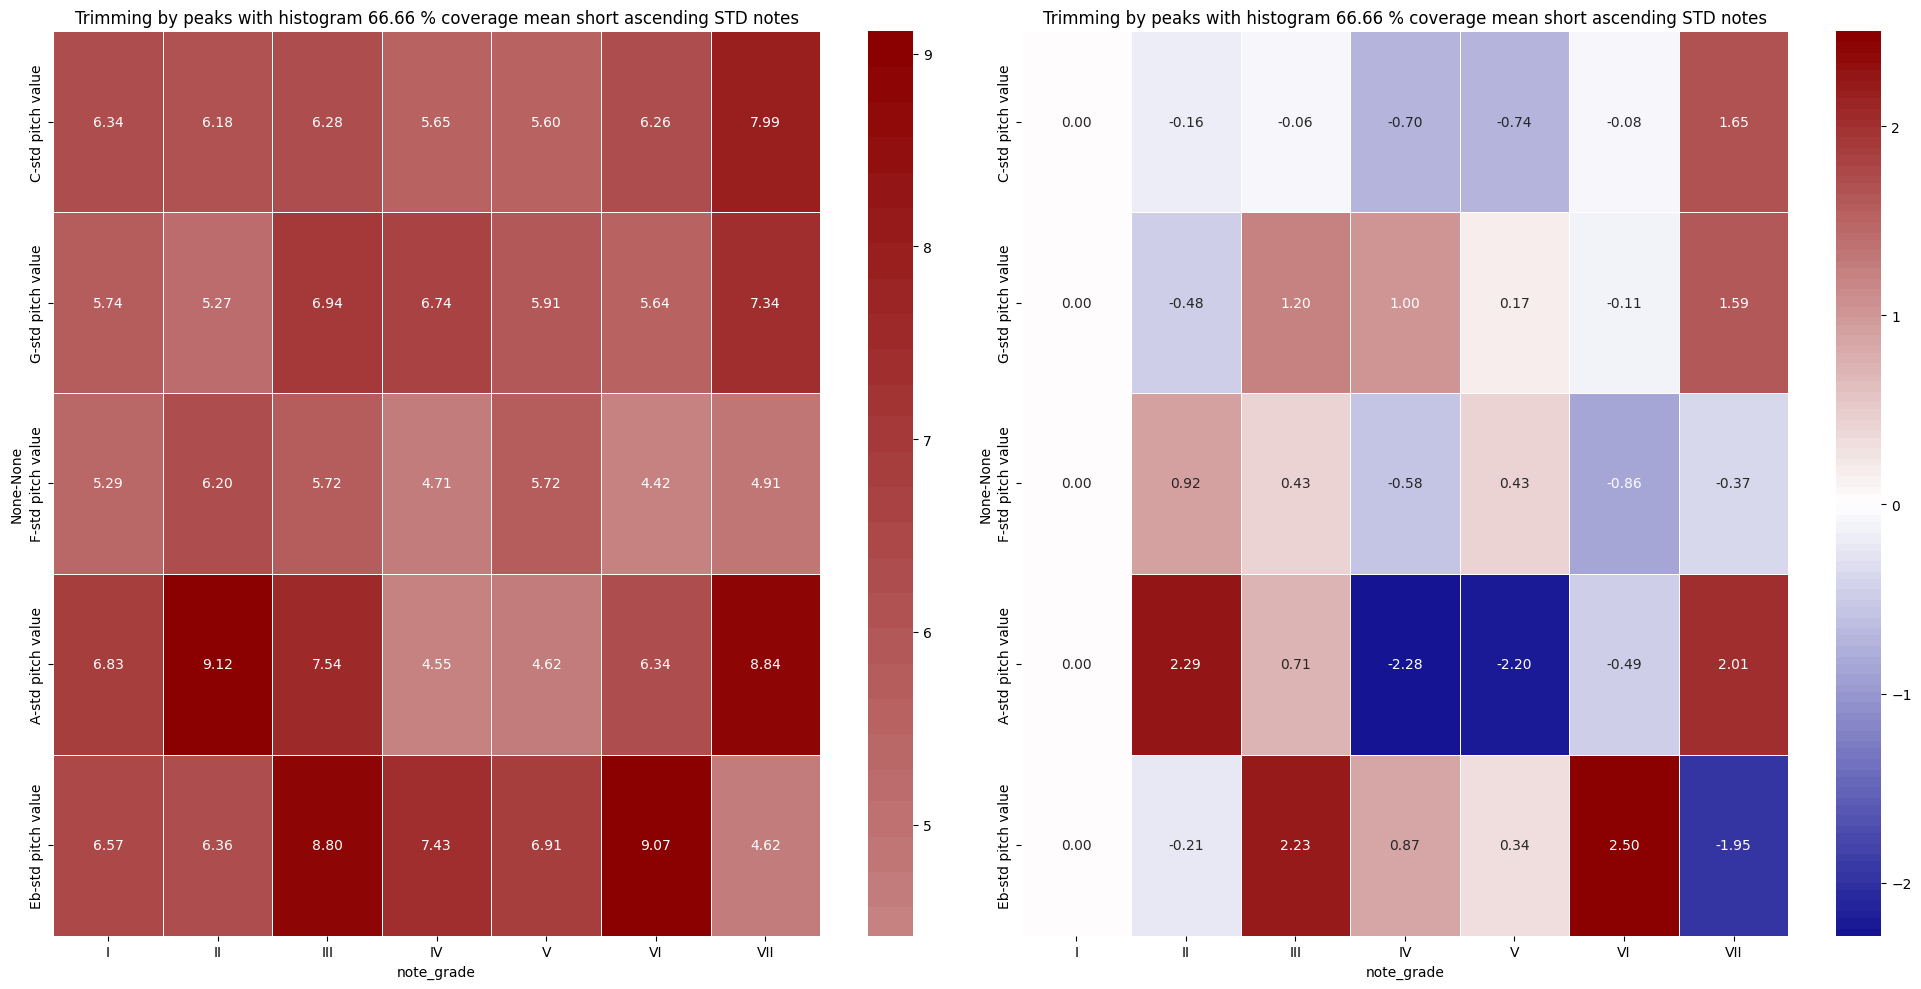

In [21]:
dict_functions.see_heatmap_zero_tonic(main_ascending_std, 'ascending STD', overall_coverage_mean)

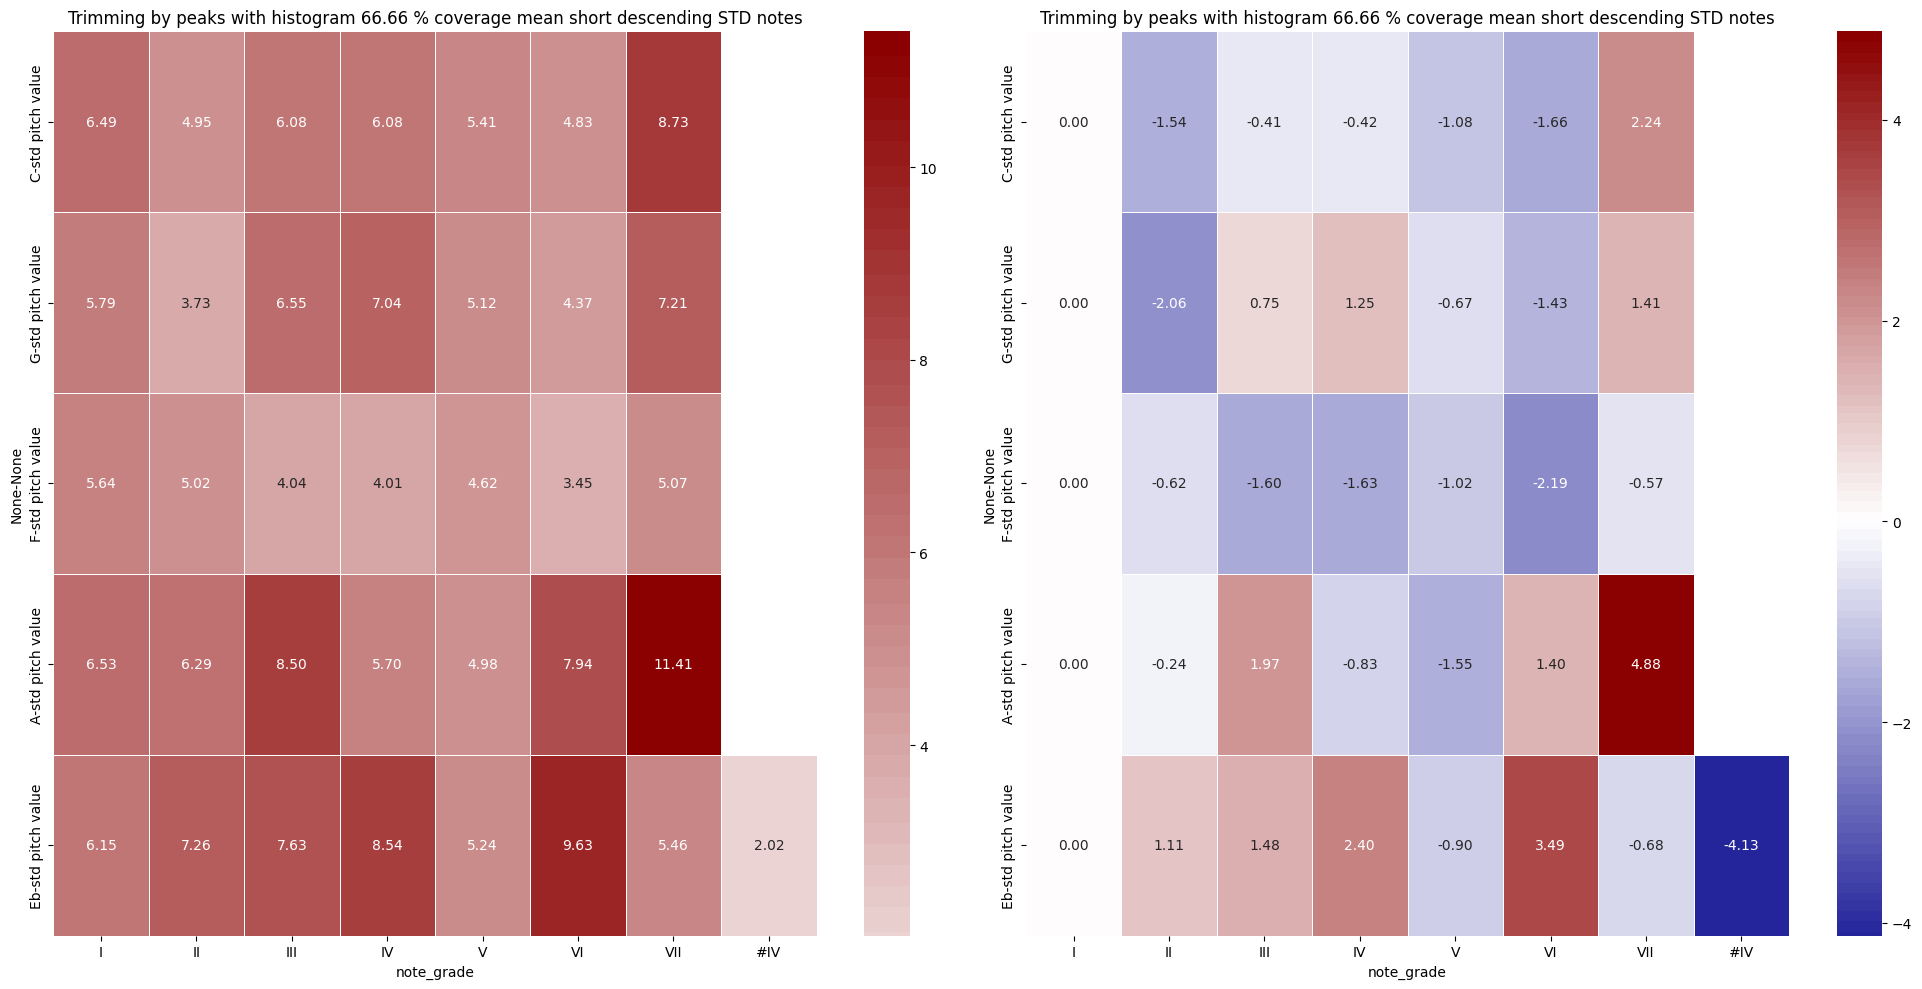

In [22]:
dict_functions.see_heatmap_zero_tonic(main_descending_std, 'descending STD', overall_coverage_mean)

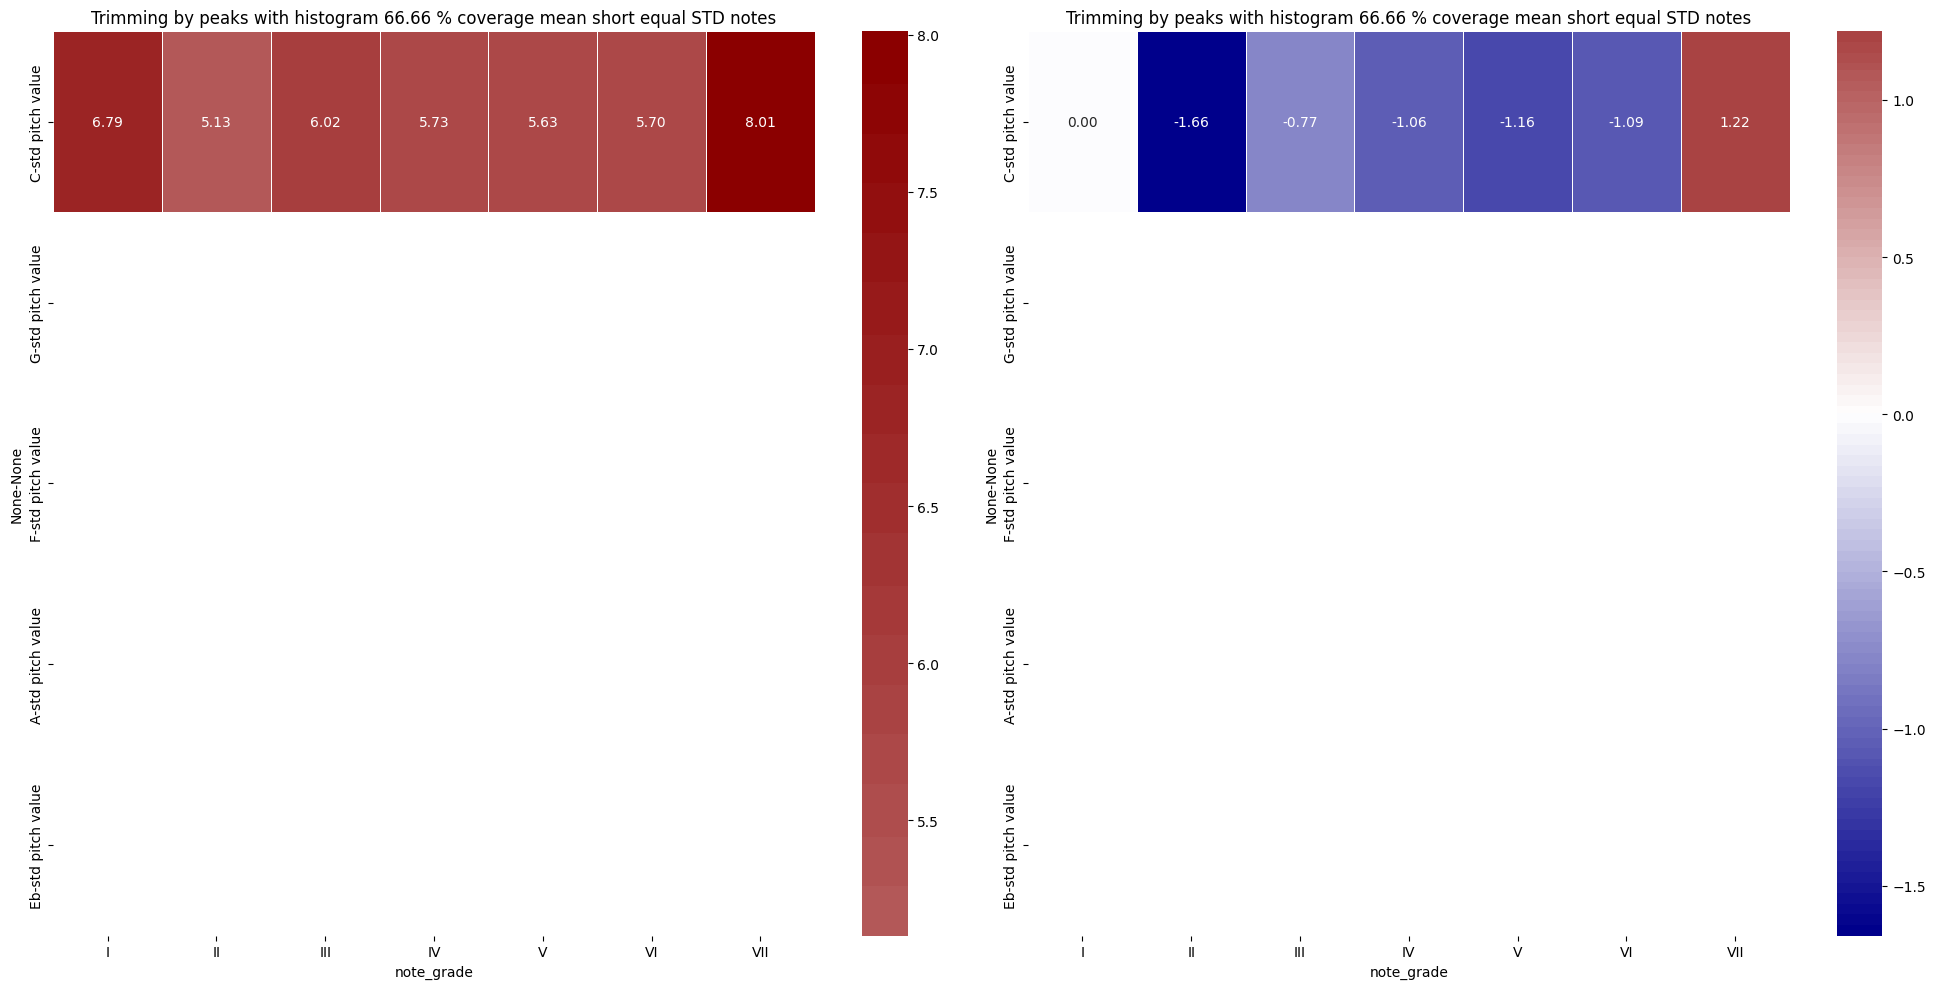

In [23]:
dict_functions.see_heatmap_zero_tonic(main_equal_std, 'equal STD', overall_coverage_mean)

## Median Direction

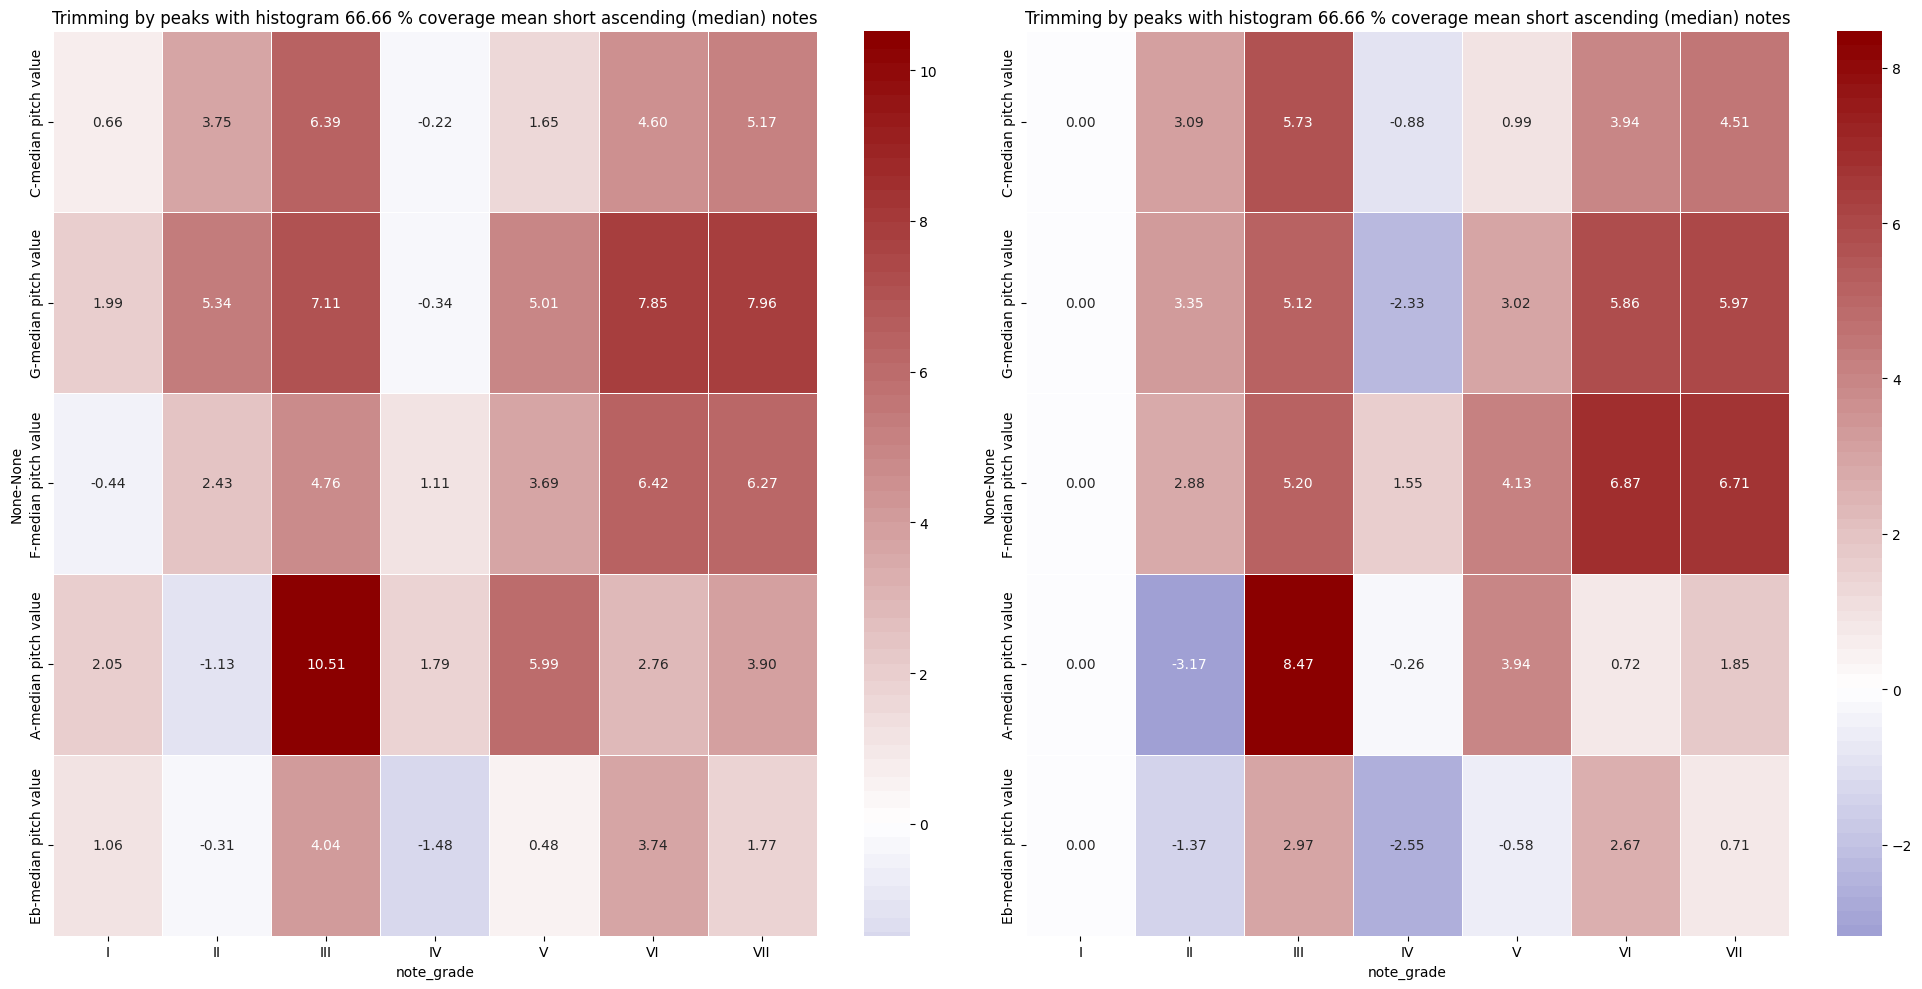

In [24]:
dict_functions.see_heatmap_zero_tonic(main_median_ascending, 'ascending (median)', overall_coverage_mean)

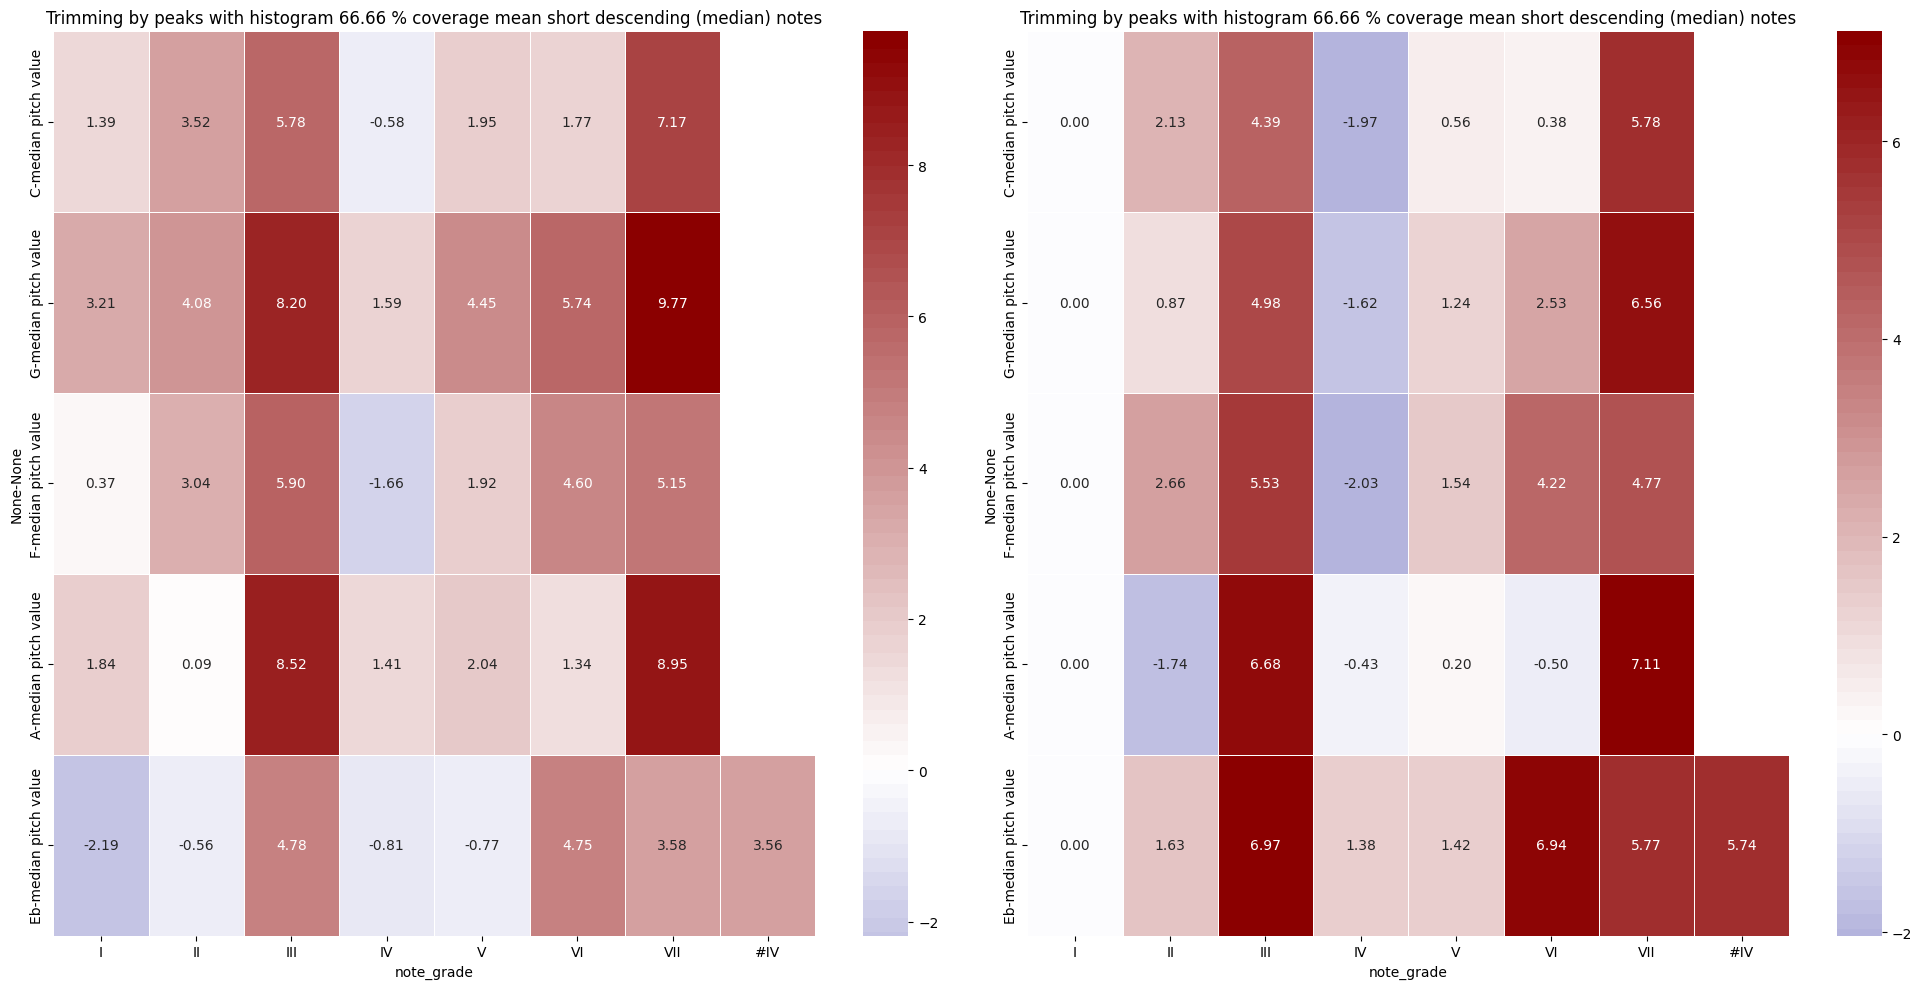

In [25]:
dict_functions.see_heatmap_zero_tonic(main_median_descending, 'descending (median)', overall_coverage_mean)

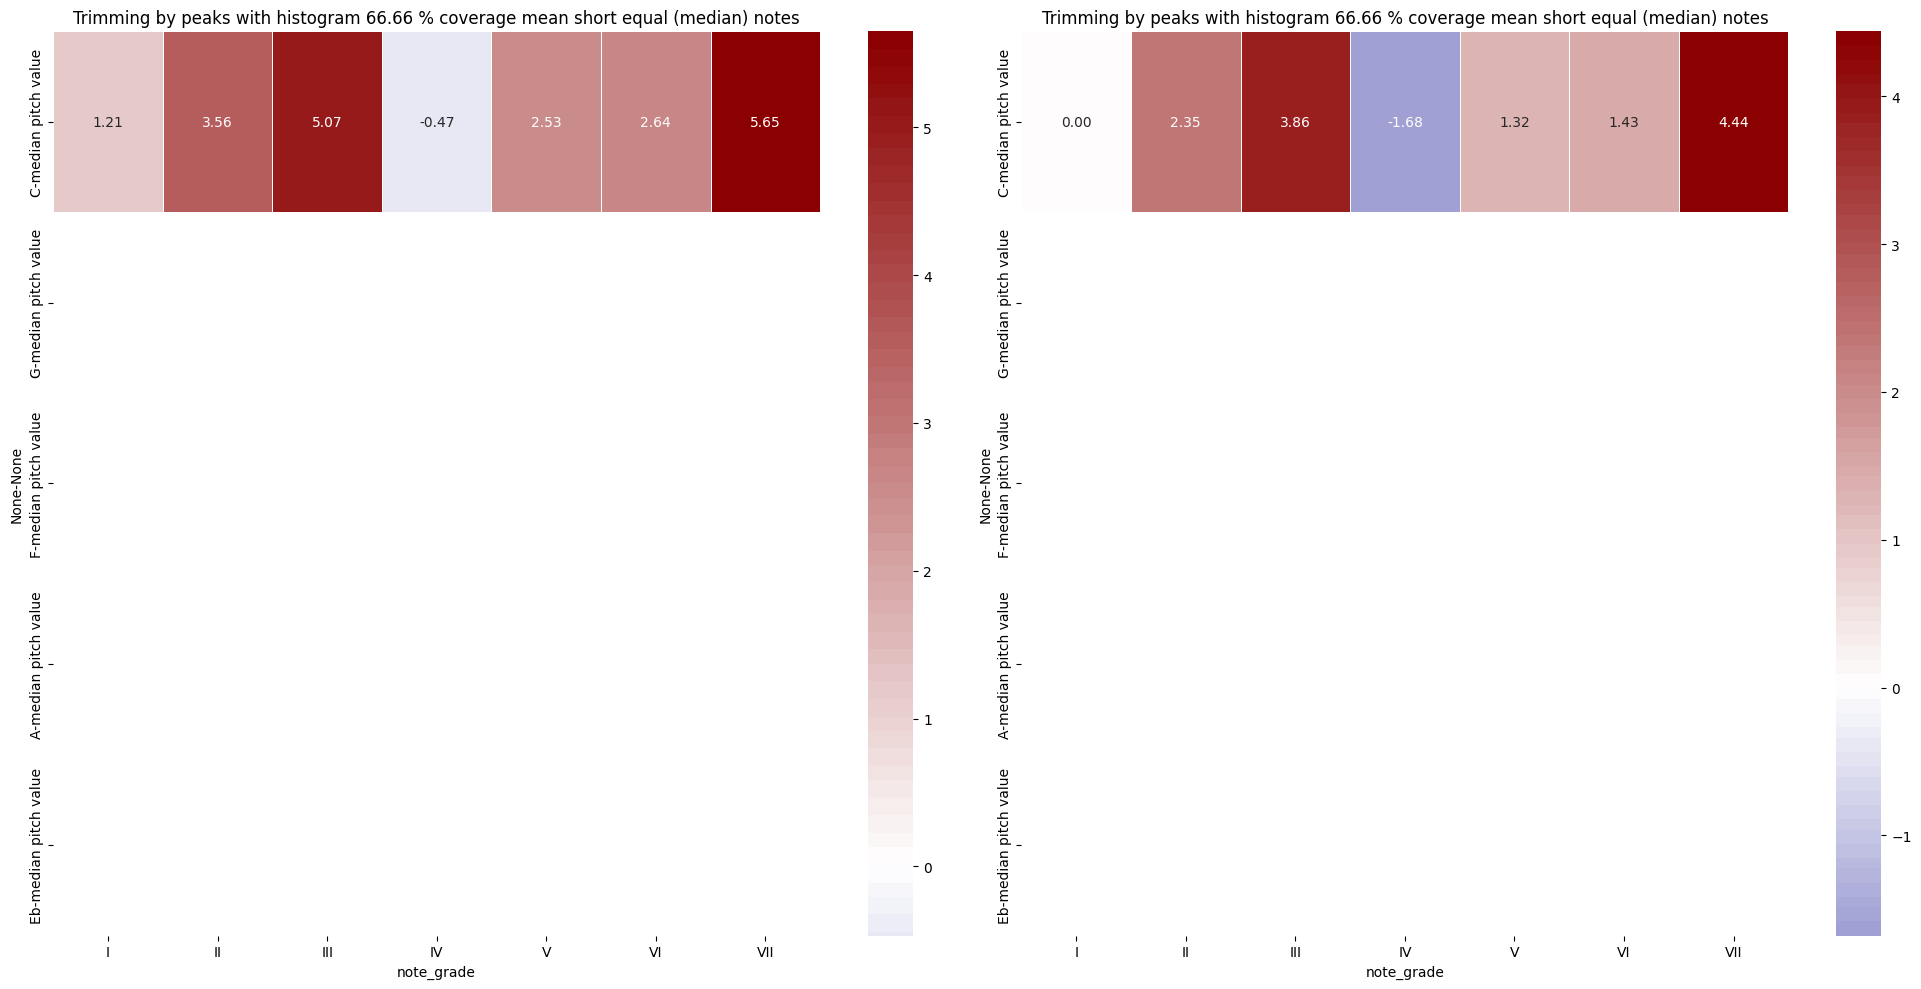

In [26]:
dict_functions.see_heatmap_zero_tonic(main_median_equal, 'equal (median)', overall_coverage_mean)

## Forward direction

In [27]:
columns = ['note_grade', 'ascending', 'descending', 'First_Note', 'equal']
df_final = pd.DataFrame(columns=columns)
short_dict_tonalities_players = {}
std_dict_tonalities_players = {}

for element in tonalities_etudes.keys():
    filtered_dict = dict_functions.filter_and_display(pshort_main_pitch_value, element, plot_yes=False)

    merged_df, names_new_columns = dict_functions.df_all_players_etude(filtered_dict, pdf_dict_short)

    merged_df = dict_functions.define_next_direction_in_df(merged_df)
    tonalitys_grades = tonalities_etudes_notetoGrades[element]

    for index, note in enumerate(merged_df['pitch']):
        if '#' in note:
            full_note = note[:2]
        else:
            full_note = note[0]

        if full_note in tonalitys_grades.keys():
            new_note = tonalitys_grades[full_note]
            merged_df.loc[index, 'note_grade'] = new_note
        else:
            print(f'Note {full_note} not found in tonality {element}')
            print('index', index)
            print('note', note)
            display(merged_df.loc[index])


    current_tonality = tonalities_etudes[element]

    merged_df['direction'] = pd.Categorical(merged_df['direction'], categories=['Ascending', 'Descending', 'Equal'], ordered=False)

    if current_tonality in short_dict_tonalities_players.keys():
        current_df = short_dict_tonalities_players[current_tonality]
        short_dict_tonalities_players[current_tonality] = pd.concat([short_dict_tonalities_players[current_tonality], merged_df])

    else:
        short_dict_tonalities_players[current_tonality] = merged_df

tonality_series = {}
tonality_std_series = {}
tonality_median_series = {}

# MEAN
tonality_series_ascending = {}
tonality_series_descending = {}
tonality_series_equal = {}

# STD
tonality_std_series_ascending = {}
tonality_std_series_descending = {}
tonality_std_series_equal = {}

# MEDIAN
tonality_median_series_ascending = {}
tonality_median_series_descending = {}
tonality_median_series_equal = {}


for current_tonality in short_dict_tonalities_players.keys():
    #display('current tonality', current_tonality)

    selected_columns = short_dict_tonalities_players[current_tonality].filter(like='pitchValue')
    selected_columns_mean = selected_columns.mean(axis=1)
    selected_columns_std = selected_columns.std(axis=1)
    selected_columns_median = selected_columns.median(axis=1)

    # MEAN
    tonality_series[current_tonality] = pd.DataFrame(selected_columns_mean)
    tonality_series[current_tonality].columns = ['mean pitch value']
    tonality_series[current_tonality]['note_grade'] = short_dict_tonalities_players[current_tonality]['note_grade']
    tonality_series[current_tonality]['pitch'] = short_dict_tonalities_players[current_tonality]['pitch']
    tonality_series[current_tonality]['direction'] = short_dict_tonalities_players[current_tonality]['direction']

    tonality_series_ascending[current_tonality] = tonality_series[current_tonality][tonality_series[current_tonality]['direction'] == 'Ascending']
    direction_columns_to_keep = [column for column in tonality_series_ascending[current_tonality].columns if 'direction' not in column or 'direction' not in column.lower()]
    tonality_series_ascending[current_tonality] = tonality_series_ascending[current_tonality][direction_columns_to_keep]

    tonality_series_descending[current_tonality] = tonality_series[current_tonality][tonality_series[current_tonality]['direction'] == 'Descending']
    direction_columns_to_keep = [column for column in tonality_series_ascending[current_tonality].columns if 'direction' not in column or 'direction' not in column.lower()]
    tonality_series_descending[current_tonality] = tonality_series_descending[current_tonality][direction_columns_to_keep]

    tonality_series_equal[current_tonality] = tonality_series[current_tonality][tonality_series[current_tonality]['direction'] == 'Equal']
    direction_columns_to_keep = [column for column in tonality_series_ascending[current_tonality].columns if 'direction' not in column or 'direction' not in column.lower()]
    tonality_series_equal[current_tonality] = tonality_series_equal[current_tonality][direction_columns_to_keep]


    # STD
    tonality_std_series[current_tonality] = pd.DataFrame(selected_columns_std)
    tonality_std_series[current_tonality].columns = ['std pitch value']
    tonality_std_series[current_tonality]['note_grade'] = short_dict_tonalities_players[current_tonality]['note_grade']
    tonality_std_series[current_tonality]['pitch'] = short_dict_tonalities_players[current_tonality]['pitch']
    tonality_std_series[current_tonality]['direction'] = short_dict_tonalities_players[current_tonality]['direction']

    tonality_std_series_ascending[current_tonality] = tonality_std_series[current_tonality][tonality_std_series[current_tonality]['direction'] == 'Ascending']
    direction_columns_to_keep_std = [column for column in tonality_std_series_ascending[current_tonality].columns if 'direction' not in column or 'direction' not in column.lower()]
    tonality_std_series_ascending[current_tonality] = tonality_std_series_ascending[current_tonality][direction_columns_to_keep_std]

    tonality_std_series_descending[current_tonality] = tonality_std_series[current_tonality][tonality_std_series[current_tonality]['direction'] == 'Descending']
    direction_columns_to_keep_std = [column for column in tonality_std_series_descending[current_tonality].columns if 'direction' not in column or 'direction' not in column.lower()]
    tonality_std_series_descending[current_tonality] = tonality_std_series_descending[current_tonality][direction_columns_to_keep_std]

    tonality_std_series_equal[current_tonality] = tonality_std_series[current_tonality][tonality_std_series[current_tonality]['direction'] == 'Equal']
    direction_columns_to_keep_std = [column for column in tonality_std_series_equal[current_tonality].columns if 'direction' not in column or 'direction' not in column.lower()]
    tonality_std_series_equal[current_tonality] = tonality_std_series_equal[current_tonality][direction_columns_to_keep_std]

    #MEDIAN
    tonality_median_series[current_tonality] = pd.DataFrame(selected_columns_median)
    tonality_median_series[current_tonality].columns = ['median pitch value']
    tonality_median_series[current_tonality]['note_grade'] = short_dict_tonalities_players[current_tonality]['note_grade']
    tonality_median_series[current_tonality]['pitch'] = short_dict_tonalities_players[current_tonality]['pitch']
    tonality_median_series[current_tonality]['direction'] = short_dict_tonalities_players[current_tonality]['direction']

    tonality_median_series_ascending[current_tonality] = tonality_median_series[current_tonality][tonality_median_series[current_tonality]['direction'] == 'Ascending']
    direction_columns_to_keep_median = [column for column in tonality_median_series_ascending[current_tonality].columns if 'direction' not in column or 'direction' not in column.lower()]
    tonality_median_series_ascending[current_tonality] = tonality_median_series_ascending[current_tonality][direction_columns_to_keep_median]

    tonality_median_series_descending[current_tonality] = tonality_median_series[current_tonality][tonality_median_series[current_tonality]['direction'] == 'Descending']
    direction_columns_to_keep_median = [column for column in tonality_median_series_descending[current_tonality].columns if 'direction' not in column or 'direction' not in column.lower()]
    tonality_median_series_descending[current_tonality] = tonality_median_series_descending[current_tonality][direction_columns_to_keep_median]

    tonality_median_series_equal[current_tonality] = tonality_median_series[current_tonality][tonality_median_series[current_tonality]['direction'] == 'Equal']
    direction_columns_to_keep_median = [column for column in tonality_median_series_equal[current_tonality].columns if 'direction' not in column or 'direction' not in column.lower()]
    tonality_median_series_equal[current_tonality] = tonality_median_series_equal[current_tonality][direction_columns_to_keep_median]



    tonality_series[current_tonality] =  tonality_series[current_tonality].groupby(['note_grade', 'direction']).mean()
    tonality_std_series[current_tonality] = tonality_series[current_tonality].groupby(['note_grade', 'direction']).mean()
    tonality_series_ascending[current_tonality] = tonality_series_ascending[current_tonality].groupby(['note_grade']).mean()
    tonality_series_descending[current_tonality] = tonality_series_descending[current_tonality].groupby(['note_grade']).mean()
    tonality_series_equal[current_tonality] = tonality_series_equal[current_tonality].groupby(['note_grade']).mean()

    tonality_std_series_ascending[current_tonality] = tonality_std_series_ascending[current_tonality].groupby(['note_grade']).mean()
    tonality_std_series_descending[current_tonality] = tonality_std_series_descending[current_tonality].groupby(['note_grade']).mean()
    tonality_std_series_equal[current_tonality] = tonality_std_series_equal[current_tonality].groupby(['note_grade']).mean()

    tonality_median_series[current_tonality] = tonality_median_series[current_tonality].groupby(['note_grade', 'direction']).mean()
    tonality_median_series_ascending[current_tonality] = tonality_median_series_ascending[current_tonality].groupby(['note_grade']).mean()
    tonality_median_series_descending[current_tonality] = tonality_median_series_descending[current_tonality].groupby(['note_grade']).mean()
    tonality_median_series_equal[current_tonality] = tonality_median_series_equal[current_tonality].groupby(['note_grade']).mean()


main_table = pd.concat(tonality_series, axis=1)
main_table_std = pd.concat(tonality_std_series, axis=1)
main_table_median = pd.concat(tonality_median_series, axis=1)


main_ascending = pd.concat(tonality_series_ascending, axis=1)
main_descending = pd.concat(tonality_series_descending, axis=1)
main_equal = pd.concat(tonality_series_equal, axis=1)

main_ascending_std = pd.concat(tonality_std_series_ascending, axis=1)
main_descending_std = pd.concat(tonality_std_series_descending, axis=1)
main_equal_std = pd.concat(tonality_std_series_equal, axis=1)

main_median_ascending = pd.concat(tonality_median_series_ascending, axis=1)
main_median_descending = pd.concat(tonality_median_series_descending, axis=1)
main_median_equal = pd.concat(tonality_median_series_equal, axis=1)

cm = sns.light_palette("green", as_cmap=True)
cm1 = sns.light_palette("red", as_cmap=True)
cm2 = sns.light_palette("blue", as_cmap=True)
cm3 = sns.light_palette("yellow", as_cmap=True)


display(main_ascending.T.style.background_gradient(cmap=cm1, axis=1))
display(main_descending.T.style.background_gradient(cmap=cm2, axis=1))
display(main_equal.T.style.background_gradient(cmap=cm3, axis=1))

display(main_ascending_std.T.style.background_gradient(cmap=cm1, axis=1))
display(main_descending_std.T.style.background_gradient(cmap=cm2, axis=1))
display(main_equal_std.T.style.background_gradient(cmap=cm3, axis=1))

display(main_median_ascending.T.style.background_gradient(cmap=cm1, axis=1))
display(main_median_descending.T.style.background_gradient(cmap=cm2, axis=1))
display(main_median_equal.T.style.background_gradient(cmap=cm3, axis=1))

,note_grade,I,II,III,IV,V,VI,VII,#IV
C,mean pitch value,1.374858,3.436314,5.539806,0.867478,1.997662,3.031338,8.027741,nan
G,mean pitch value,2.881292,3.910879,8.385580,1.716915,3.038461,6.603226,10.185611,nan
F,mean pitch value,-0.029426,1.120813,4.548775,-0.155914,3.014955,3.416439,5.519013,nan
A,mean pitch value,0.792582,-0.601737,7.755346,2.108126,1.268397,1.845852,2.363933,nan
Eb,mean pitch value,-0.895736,0.479208,4.327598,-0.745734,0.264066,5.332190,3.225152,4.428385


,note_grade,I,II,III,IV,V,VI,VII,#IV
C,mean pitch value,1.231012,4.348272,5.744074,-0.437762,3.074207,3.805672,6.093801,nan
G,mean pitch value,2.868153,5.910345,8.334979,1.272476,4.954414,7.547391,8.828839,nan
F,mean pitch value,-0.387213,3.839524,6.326189,0.576170,2.087707,7.534274,5.328943,nan
A,mean pitch value,2.368358,1.176208,8.098846,1.312503,3.855572,3.389422,6.608656,nan
Eb,mean pitch value,0.238039,-0.254607,5.382959,0.242440,0.768132,4.406161,3.632792,3.550791


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,note_grade,I,II,III,IV,V,VI,VII
C,mean pitch value,0.785520,2.815346,5.381238,-0.606216,1.349590,2.164354,6.347633
G,mean pitch value,nan,nan,nan,nan,nan,nan,nan
F,mean pitch value,nan,nan,nan,nan,nan,nan,nan
A,mean pitch value,nan,nan,nan,nan,nan,nan,nan
Eb,mean pitch value,nan,nan,nan,nan,nan,nan,nan


,note_grade,I,II,III,IV,V,VI,VII,#IV
C,std pitch value,6.341861,5.234017,5.380211,5.212602,5.455492,5.530120,8.767170,nan
G,std pitch value,5.340258,4.296476,6.214754,6.814657,4.280068,5.137034,6.984972,nan
F,std pitch value,5.457363,5.645749,4.369196,3.803849,5.683073,2.464867,4.718263,nan
A,std pitch value,6.173646,7.410165,8.245813,3.469590,6.480423,6.501344,10.426235,nan
Eb,std pitch value,5.797885,6.332976,8.187382,7.067444,4.806077,9.371522,4.613656,2.562382


,note_grade,I,II,III,IV,V,VI,VII,#IV
C,std pitch value,6.414417,4.984967,7.072322,6.039019,5.841748,5.647371,8.112663,nan
G,std pitch value,6.209298,4.914178,7.135017,6.985142,6.092809,5.174800,7.521413,nan
F,std pitch value,5.485946,5.409374,5.527480,4.907988,4.609468,5.017436,5.358658,nan
A,std pitch value,6.993321,8.195176,8.329468,6.327366,4.147402,7.349259,11.037531,nan
Eb,std pitch value,6.731217,7.230849,8.470914,8.443743,7.069541,9.430342,5.929666,1.479310


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,note_grade,I,II,III,IV,V,VI,VII
C,std pitch value,6.801624,5.730461,5.739863,5.897549,5.446927,5.699959,7.888800
G,std pitch value,nan,nan,nan,nan,nan,nan,nan
F,std pitch value,nan,nan,nan,nan,nan,nan,nan
A,std pitch value,nan,nan,nan,nan,nan,nan,nan
Eb,std pitch value,nan,nan,nan,nan,nan,nan,nan


,note_grade,I,II,III,IV,V,VI,VII,#IV
C,median pitch value,1.323225,3.808711,5.419234,0.749533,2.184679,2.772202,6.885997,nan
G,median pitch value,2.850315,3.767007,7.633732,1.316985,3.007787,5.782679,9.468542,nan
F,median pitch value,0.065193,1.489623,4.887868,-0.192612,3.521141,3.613345,5.973694,nan
A,median pitch value,2.034435,-0.812074,8.264129,2.405058,0.782189,-0.129950,3.240770,nan
Eb,median pitch value,-1.496662,-0.161832,3.718909,-2.146219,-0.199342,4.543878,2.915475,3.650513


,note_grade,I,II,III,IV,V,VI,VII,#IV
C,median pitch value,1.064674,4.125329,5.744381,-0.620006,3.069928,4.065602,5.771490,nan
G,median pitch value,2.826888,5.958061,7.911328,0.150670,5.383175,7.421899,8.749892,nan
F,median pitch value,-0.048168,3.692580,6.317120,0.179427,2.282830,6.929493,5.218210,nan
A,median pitch value,1.860715,-0.021988,9.332391,0.967957,3.392978,2.776992,9.614975,nan
Eb,median pitch value,-0.450935,-0.621629,4.898236,-0.706051,-0.072653,4.212939,3.320936,3.466581


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,note_grade,I,II,III,IV,V,VI,VII
C,median pitch value,0.760162,3.046899,5.930701,-0.810841,1.117715,2.136496,5.819986
G,median pitch value,nan,nan,nan,nan,nan,nan,nan
F,median pitch value,nan,nan,nan,nan,nan,nan,nan
A,median pitch value,nan,nan,nan,nan,nan,nan,nan
Eb,median pitch value,nan,nan,nan,nan,nan,nan,nan


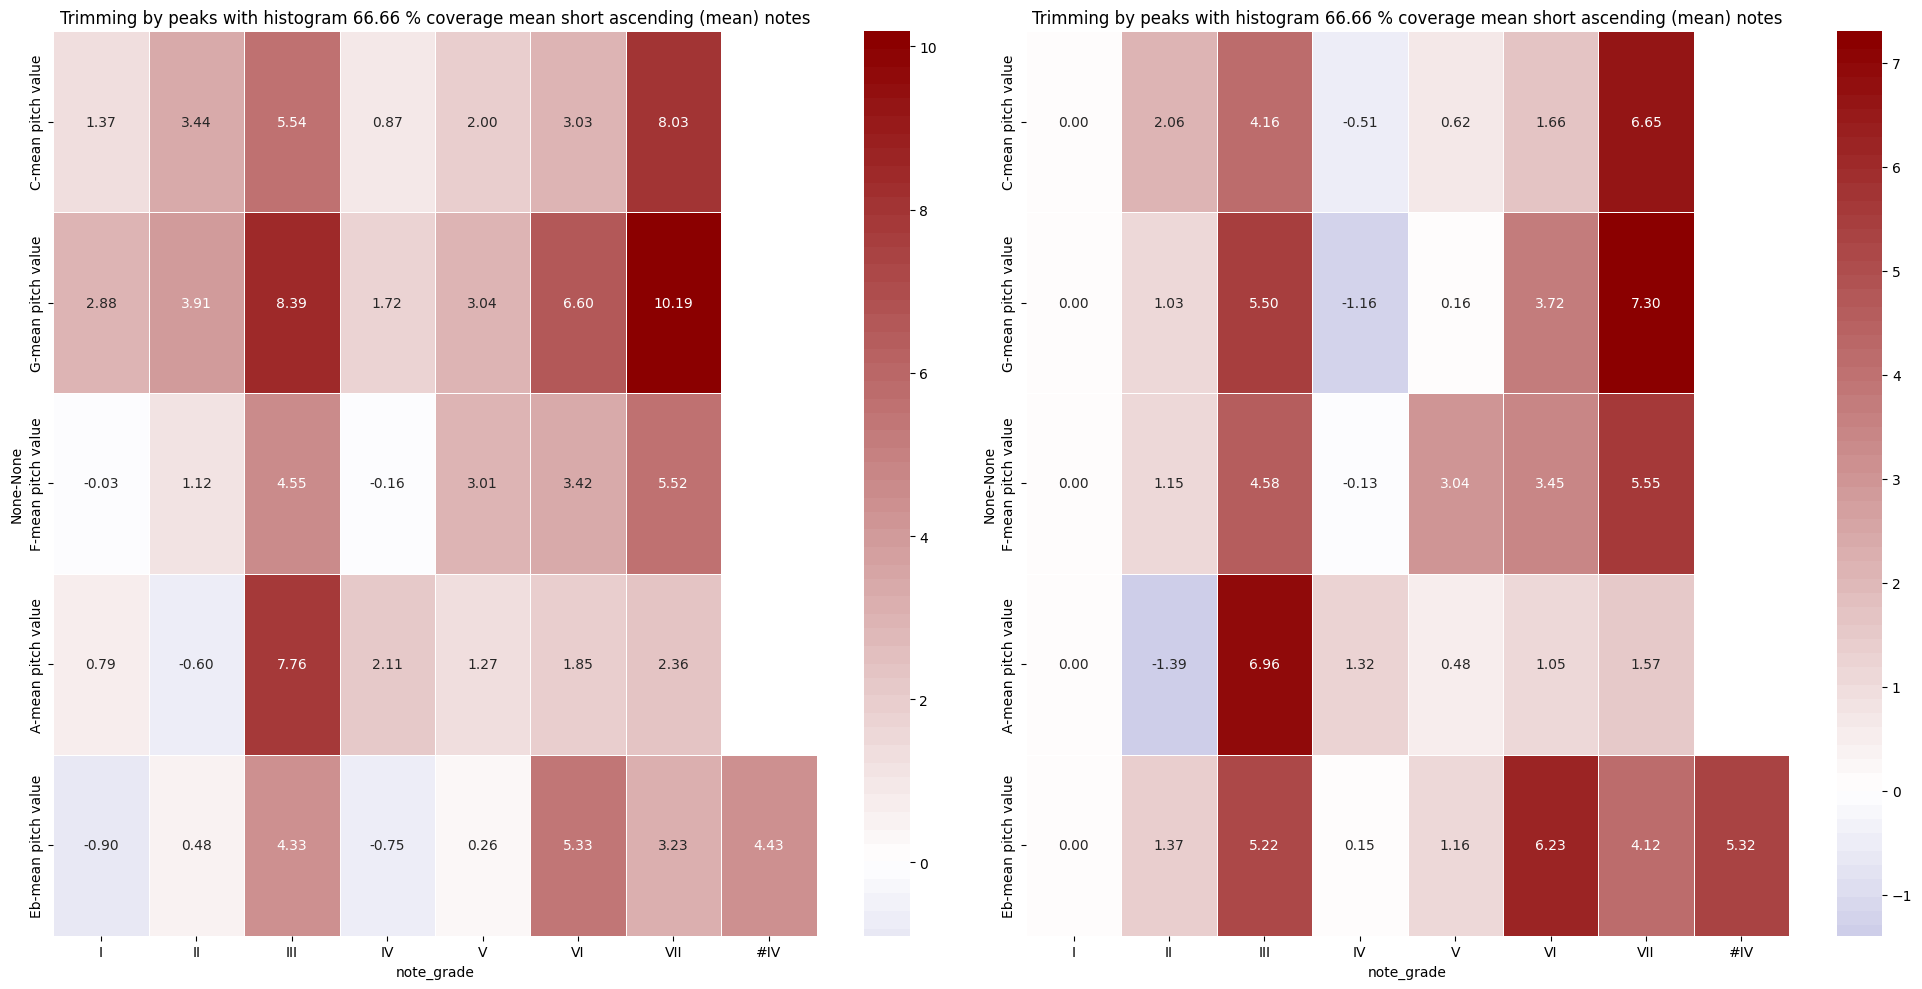

In [28]:
dict_functions.see_heatmap_zero_tonic(main_ascending, 'ascending (mean)', overall_coverage_mean)

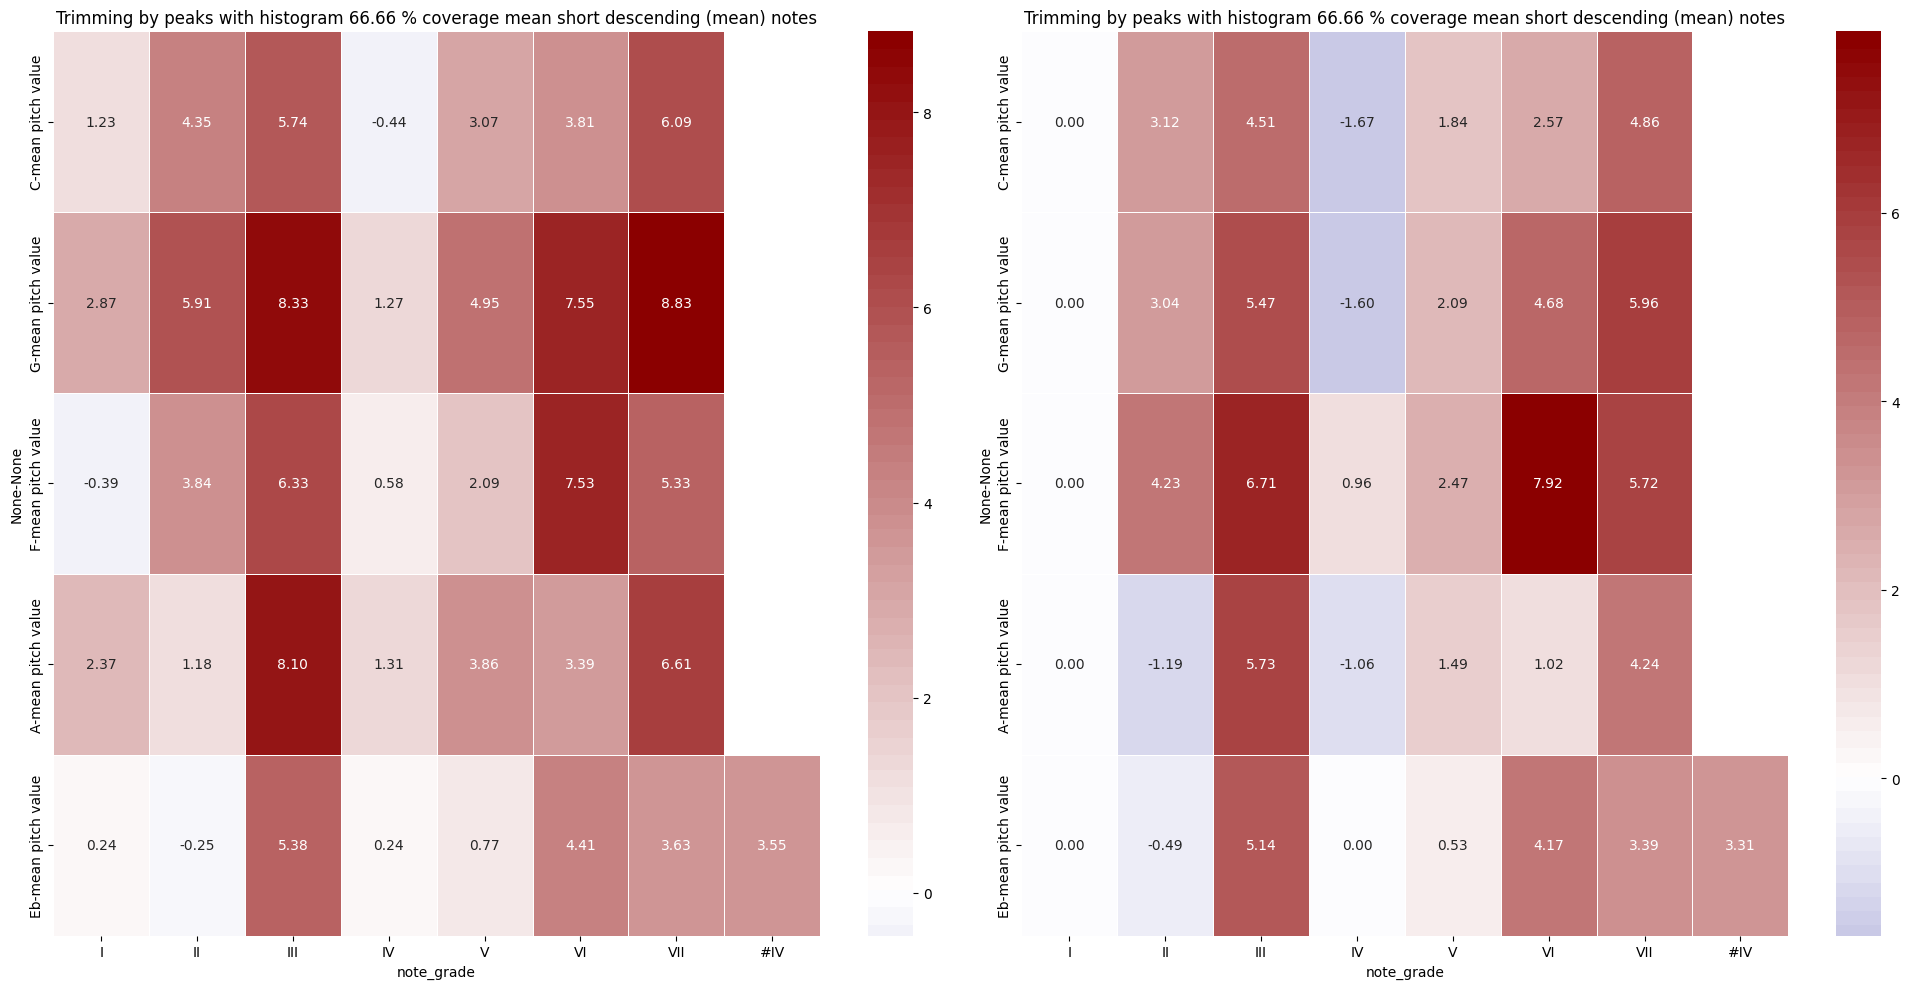

In [29]:
dict_functions.see_heatmap_zero_tonic(main_descending, 'descending (mean)', overall_coverage_mean)

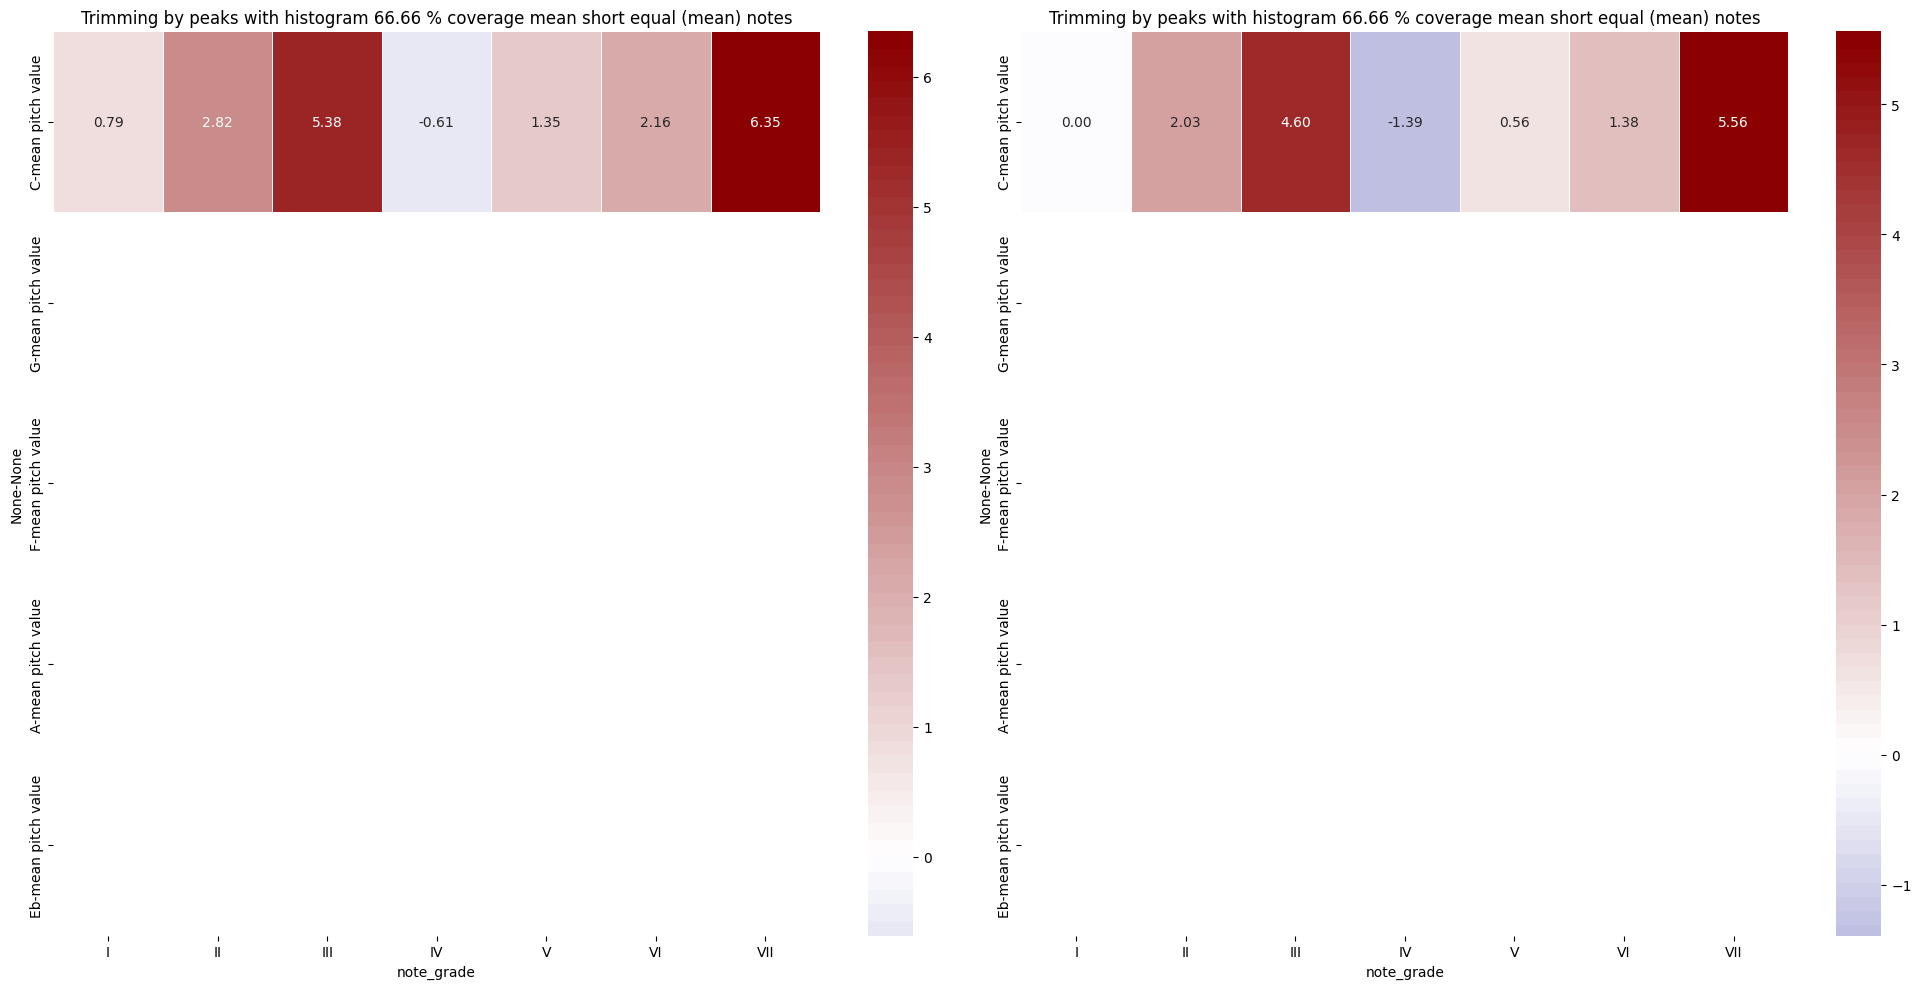

In [30]:
dict_functions.see_heatmap_zero_tonic(main_equal, 'equal (mean)', overall_coverage_mean)

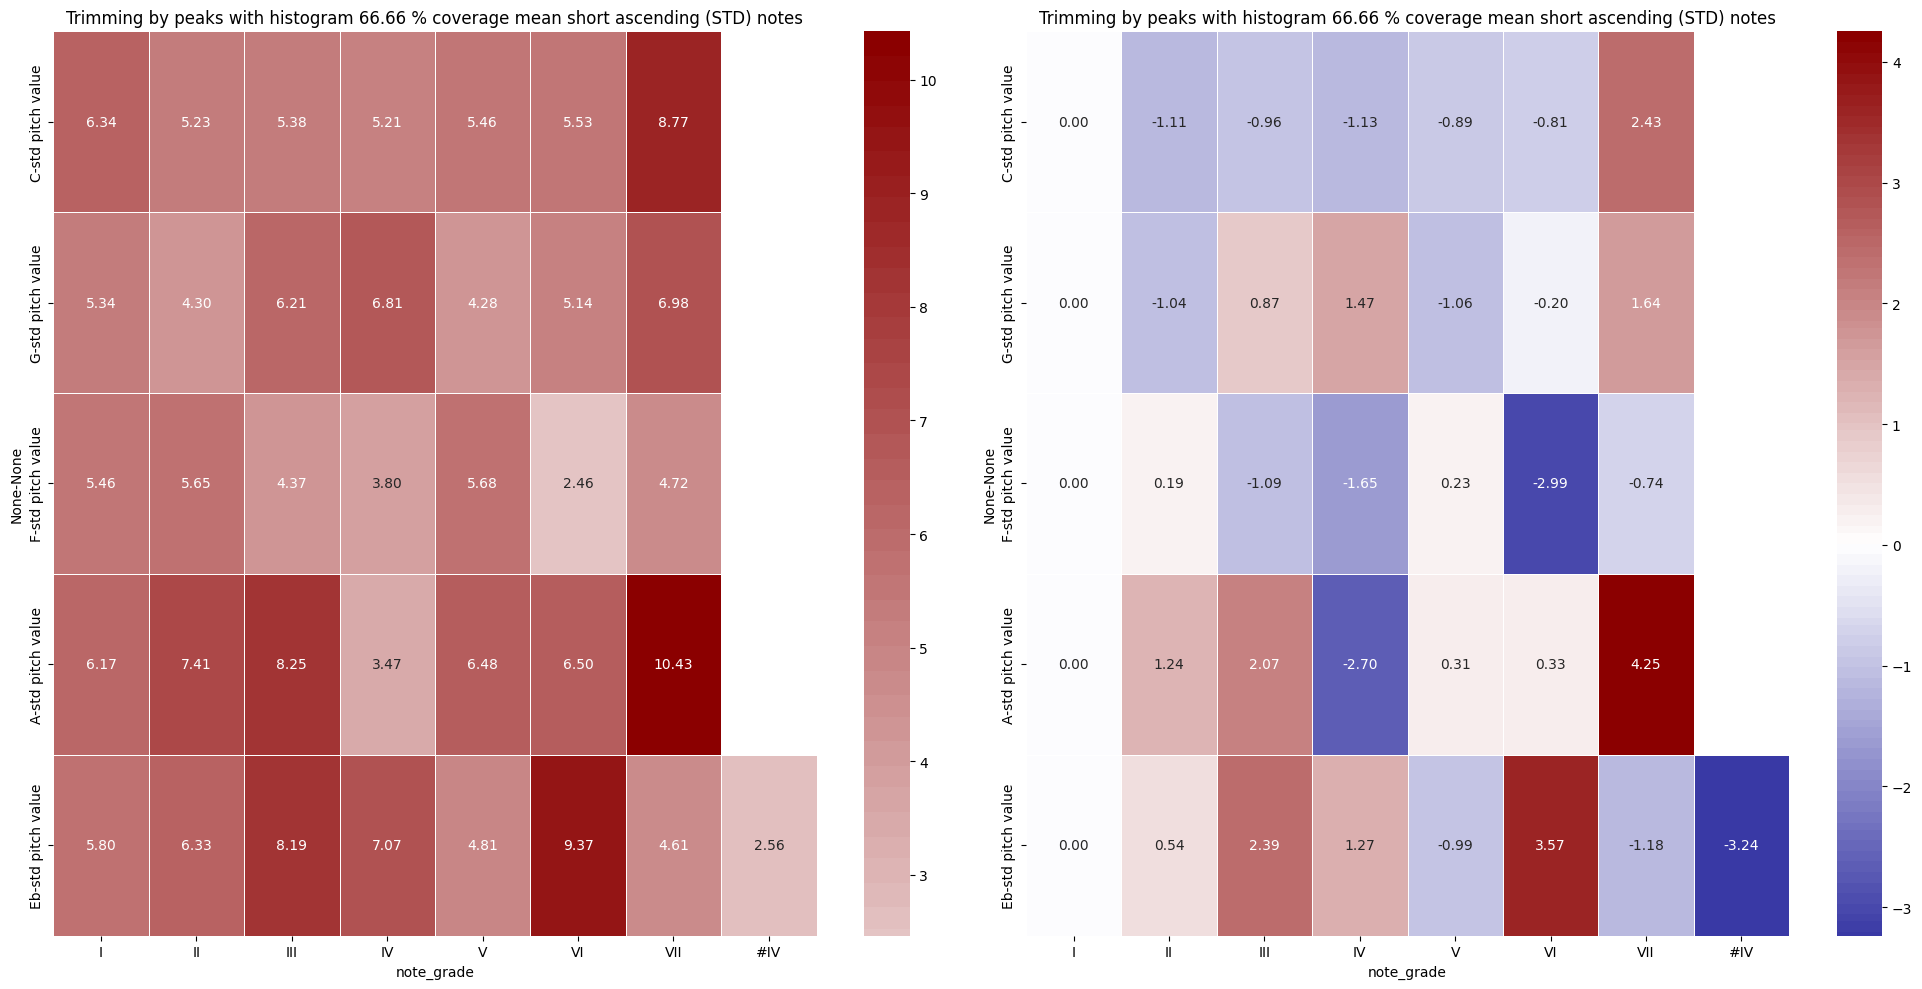

In [31]:
dict_functions.see_heatmap_zero_tonic(main_ascending_std, 'ascending (STD)', overall_coverage_mean)

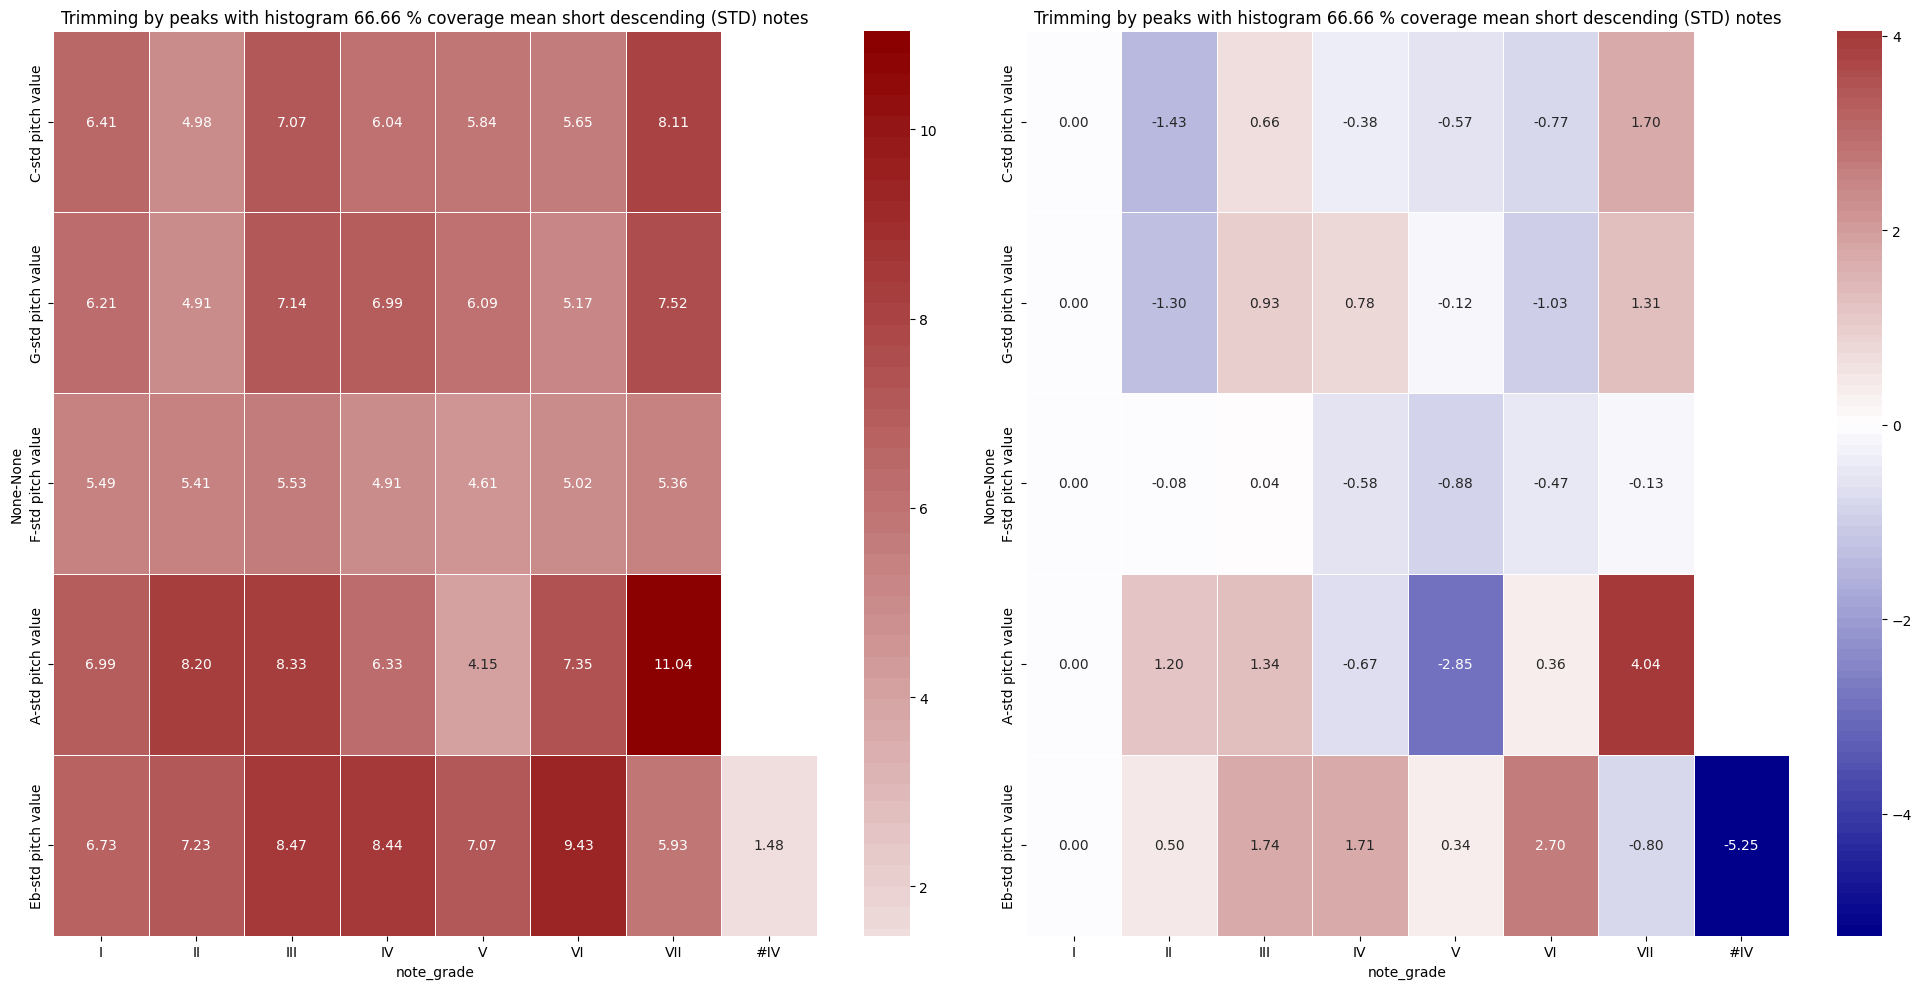

In [32]:
dict_functions.see_heatmap_zero_tonic(main_descending_std, 'descending (STD)', overall_coverage_mean)

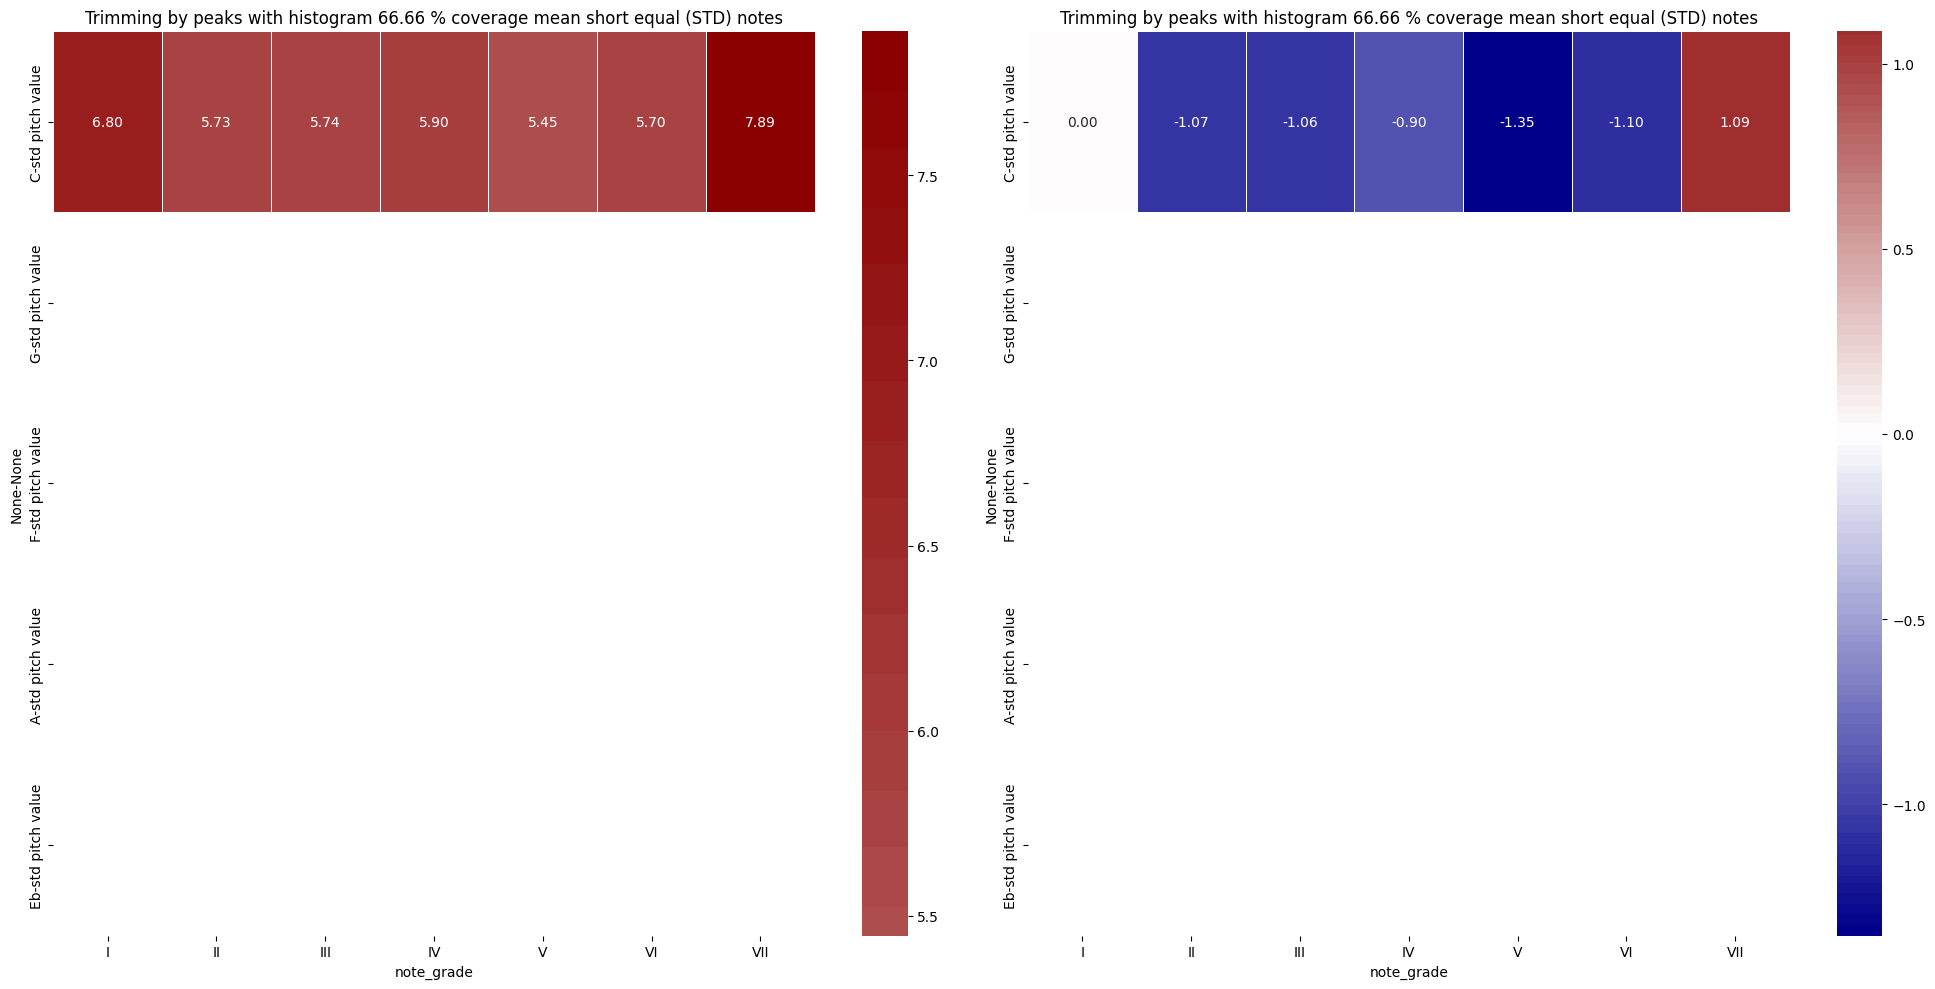

In [33]:
dict_functions.see_heatmap_zero_tonic(main_equal_std, 'equal (STD)', overall_coverage_mean)

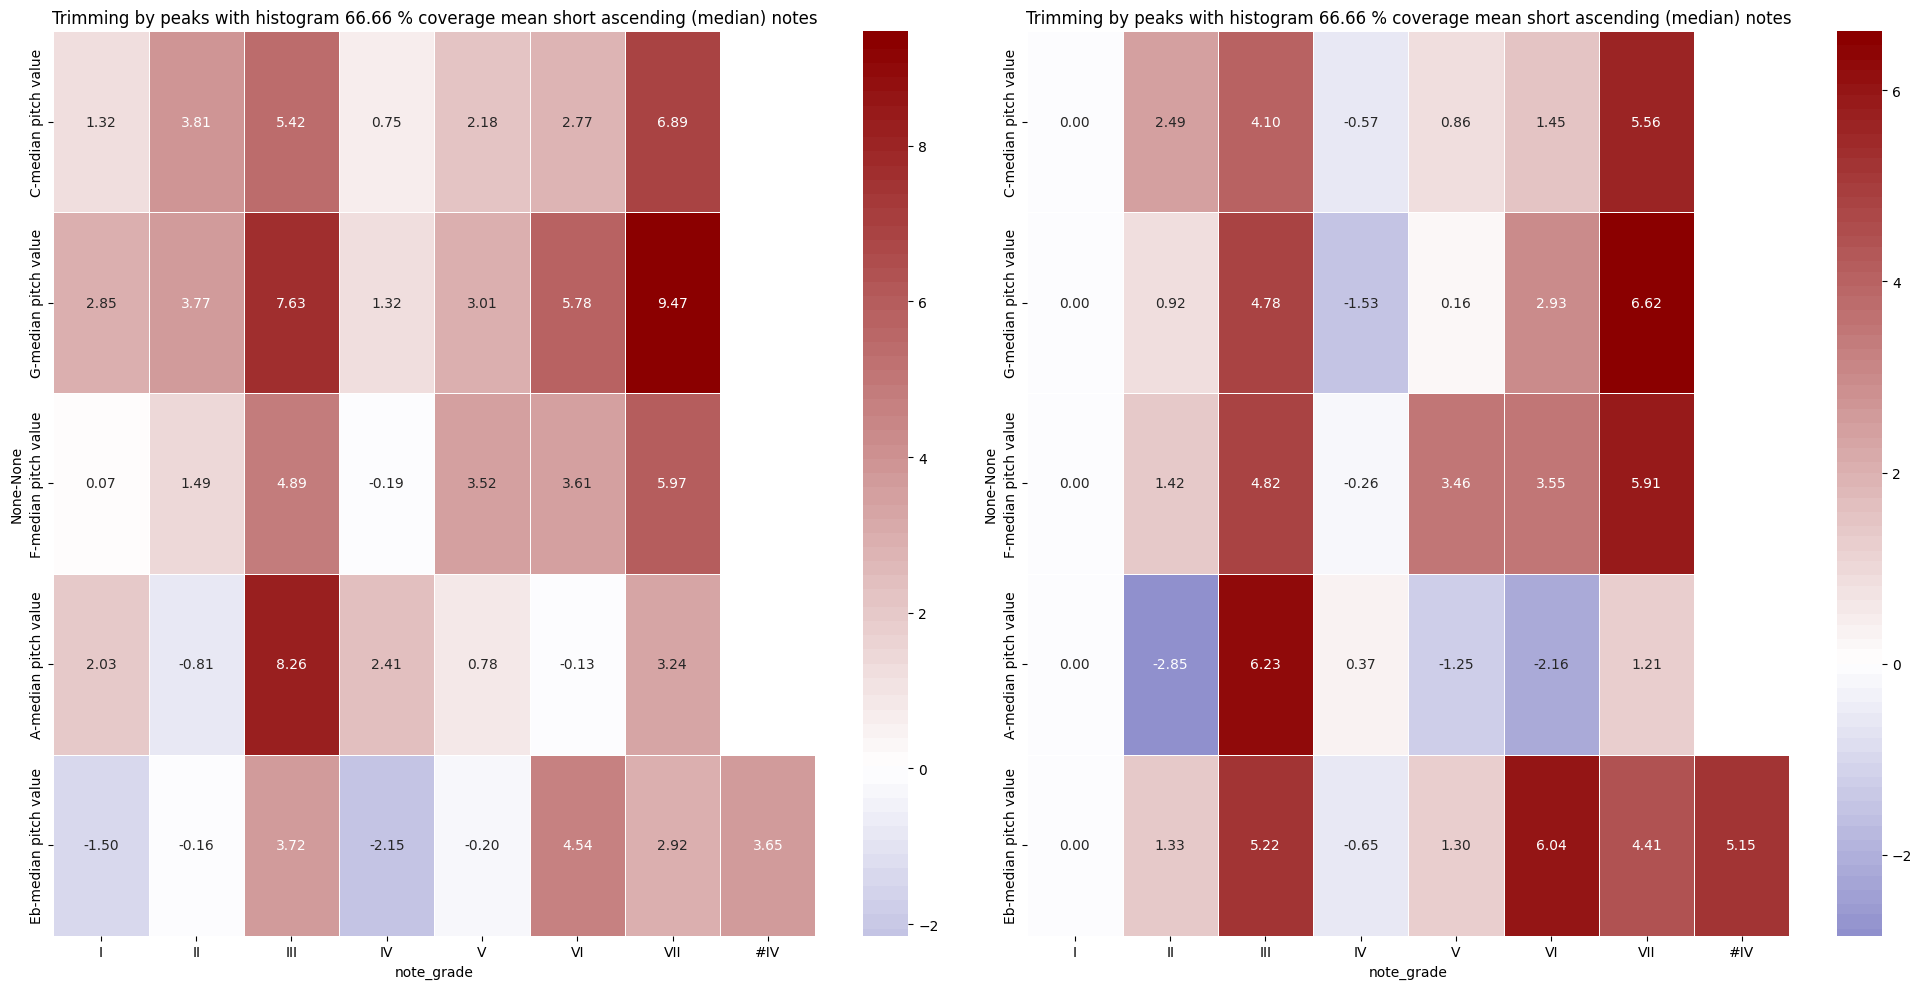

In [34]:
dict_functions.see_heatmap_zero_tonic(main_median_ascending, 'ascending (median)', overall_coverage_mean)

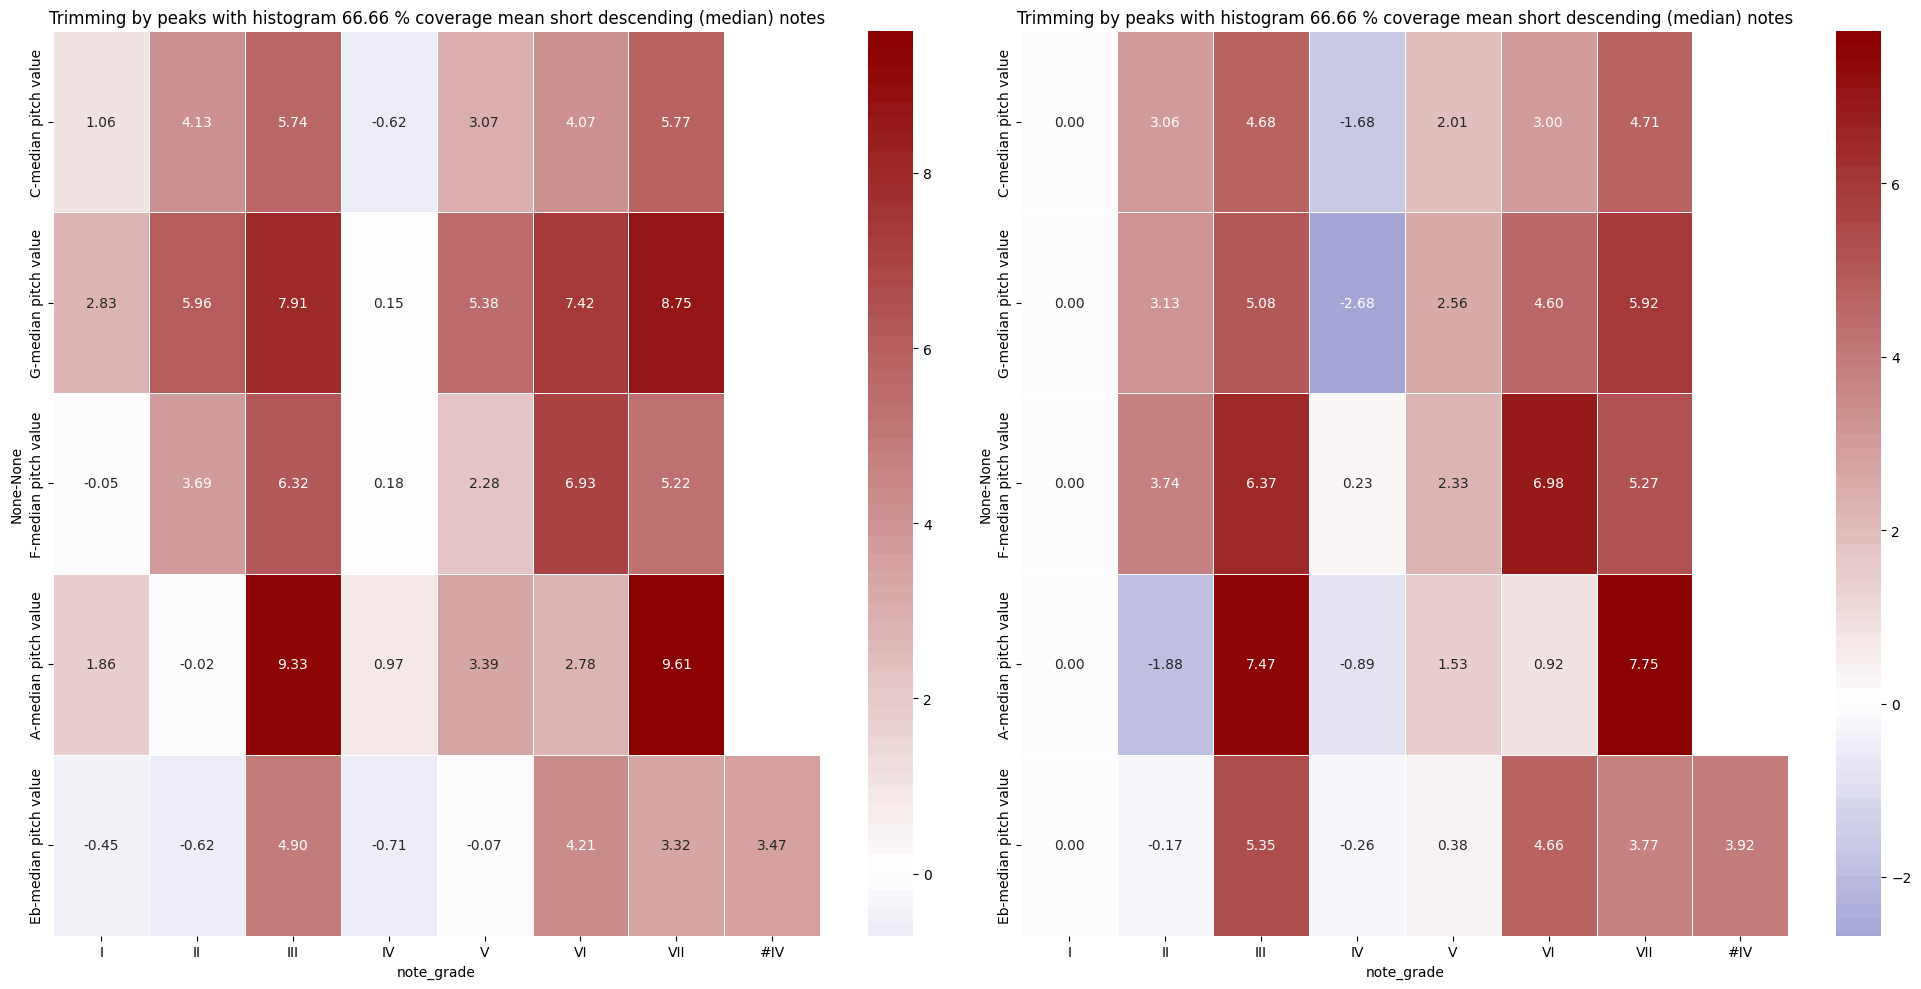

In [35]:
dict_functions.see_heatmap_zero_tonic(main_median_descending, 'descending (median)', overall_coverage_mean)

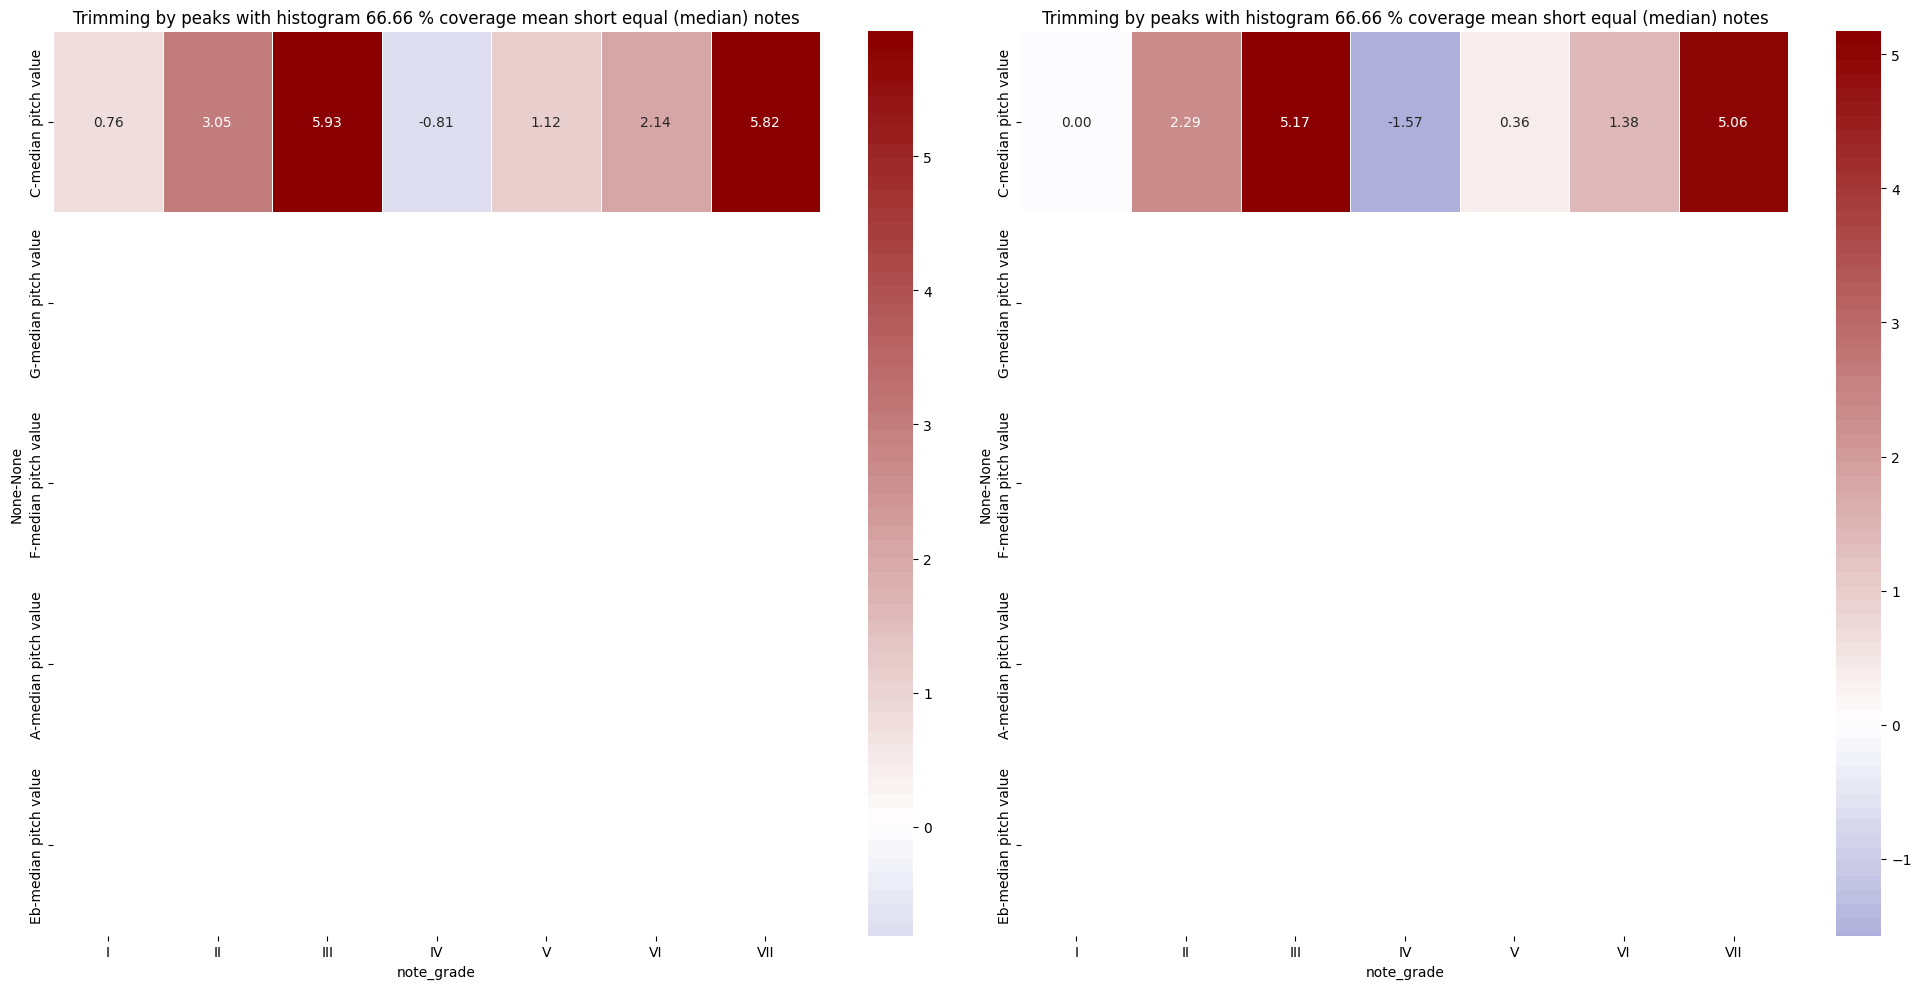

In [36]:
dict_functions.see_heatmap_zero_tonic(main_median_equal, 'equal (median)', overall_coverage_mean)